# Delayed Self-Heterodyne Phase Noise Measurements With Coherent Phase Modulation Detection

This notebook focuses on metodologies presented in the work: 

[Delayed Self-Heterodyne Phase Noise Measurements With Coherent Phase Modulation Detection (2012)](https://ieeexplore.ieee.org/document/6064871)


I am starting with this work, because it study a system with only one laser

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
from optic.models.devices import photodiode, basicLaserModel
from optic.models.channels import linearFiberChannel
from optic.dsp.core import phaseNoise, firFilter, pulseShape, signal_power ,delaySignal
from optic.models.amplification import OSA, get_spectrum
from optic.utils import parameters
from optic.plot import plotPSD
from scipy.constants import h, c
import scipy.signal as signal
from scipy.signal import hilbert
from scipy.signal.windows import hamming
from scipy.ndimage import shift
from IPython.display import display, Math
from commpy.utilities import upsample
from tqdm.notebook import tqdm  # Needs installation of jupyter and ipywidgets packages

sys.path.append('..\..\Functions')

from laser_dfb import *
from laser_cw import *
from AuxiliaryFunctions import *

fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

# Optical domain demonstration: 50:50 Coupling, SMF, and PM modulation

![Self-Heterodyne Setup](../../IlustrationMedia/Delayed_Self_Heterodyne/Self-heterodyne_PM_detection_method.png)

## Laser generation

In [6]:
laser_dfb_parameters = parameters()
laser_dfb_parameters.noise_terms = True
laser_dfb_parameters.v       = 1.0       # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 0.33e-9   # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.50e-6   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 4.52e+9   # [cm/s] group velocity
laser_dfb_parameters.n_t     = 8.2e6     # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 4.58e-8   # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 7.15e-12  # [s] photon lifetime
laser_dfb_parameters.gamma   = 1.0       # mode confinement factor
laser_dfb_parameters.beta    = 3.54e-5   # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 10*1.55         # linewidth enchancement factor (default is 1.55)
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.0129    # [A] i_bias
laser_dfb_parameters.i_max   = 0.0300    # [A] i_max
laser_dfb_parameters.eta_0   = 0.21      # total differential quantum efficiency
laser_dfb_parameters.lmbd    = 1540e-9   # [m] wavelength

In [2]:
# simulation parameters
SpS = 256    # Samples per Symbol
Rs = 2.5e9   # Symbol rate (for OOK case Rs = Rb)

Tsymb = 1/Rs       # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.ones(2**9)
n = np.arange(0, bitsTx.size)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting (not necessary for CW operation)
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])  # Shifts the signal to the right and fill the new created empty values with a constant = cval 
t = np.arange(0,SpS*len(bitsTx))*Ts

print(f'Samples: {SpS*len(bitsTx)}')

Samples: 131072


Solving ODEs... Showing steps taken (compared to t_eval):   0%|          | 0/131072 [00:00<?, ?it/s]

c:\Users\Caio\Documents\GitHub\Laser-Study\Projects\Delayed_Self_Heterodyne\..\..\Functions\laser_dfb.py:125: RuntimeWarning: invalid value encountered in sqrt
  fs = np.random.randn()*np.sqrt(2*dss/self.t_step)
c:\Users\Caio\Documents\GitHub\Laser-Study\Projects\Delayed_Self_Heterodyne\..\..\Functions\laser_dfb.py:127: RuntimeWarning: invalid value encountered in sqrt
  fp = np.random.randn()*np.sqrt(2*dpp/self.t_step)


I_threshold: 9.990 mA
I_on: 42.900 mA
I_off: 42.900 mA
Power (mW): 2.748646878705547


c:\Users\Caio\Documents\GitHub\Laser-Study\.venv\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Caio\Documents\GitHub\Laser-Study\.venv\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


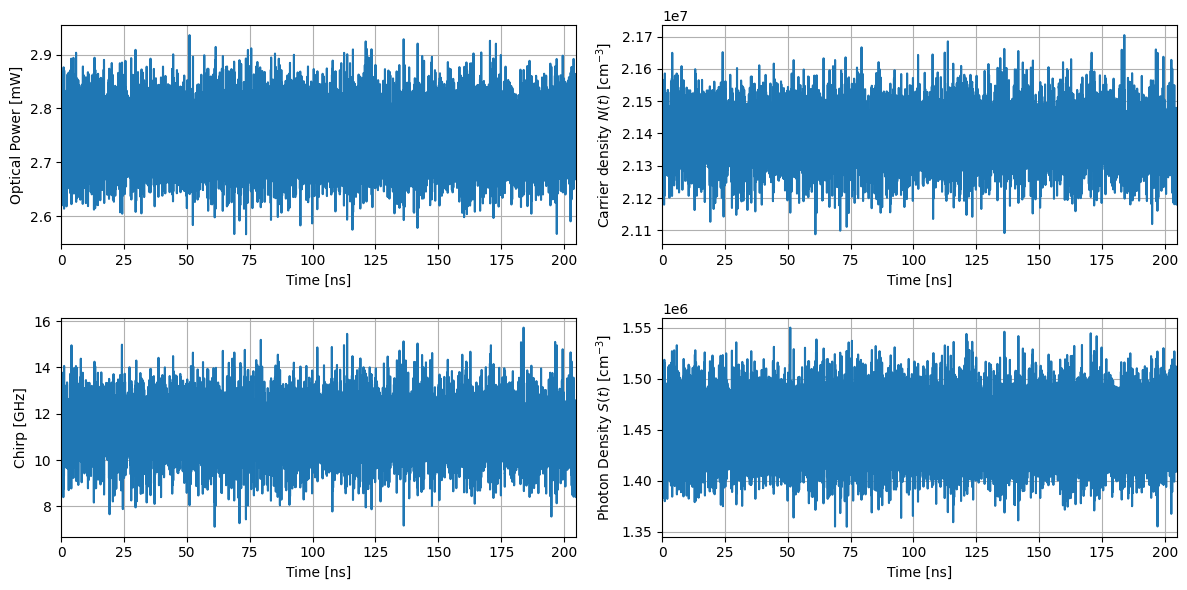

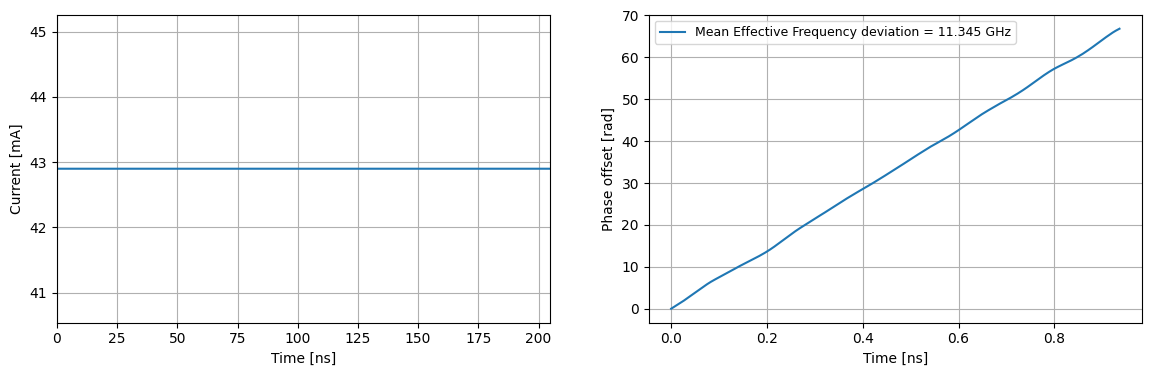

In [8]:
laser_dfb_parameters.noise_terms = True
laser1 = laser_dfb(laser_dfb_parameters)
sol = laser1.solve(t, sigTx)

picklepath = 'Data/'
checkpoint_count = sum(len(files) for _, _, files in os.walk(picklepath))
SaveFile = {}

SaveFile['N'] = laser1.N
SaveFile['S'] = laser1.S
SaveFile['phase'] = laser1.phase
SaveFile['power'] = laser1.power
SaveFile['chirp'] = laser1.chirp
SaveFile['e_out'] = laser1.e_out
SaveFile['current'] = laser1.current
SaveFile['t'] = laser1.t
SaveFile['lmbd'] = laser1.lmbd
SaveFile['SpS'] = SpS
SaveFile['Rs'] = Rs
with open(picklepath+'Dataset('+str(checkpoint_count+1)+').pickle','wb') as handle:
    pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)

laser1.plot()
print('I_threshold: %.3f mA'%(1e3*laser1.ith))
print('I_on: %.3f mA'%(1e3*np.real(laser1.current.max())))
print('I_off: %.3f mA'%(1e3*np.real(laser1.current.min())))
print(f'Power (mW): {np.mean(laser1.power)*1e3}')

fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(14)

ax[0].plot(1e9*laser1.t, 1e3*laser1.current)
ax[0].set_xlabel('Time [ns]')
ax[0].set_ylabel('Current [mA]')
ax[0].set_xlim([1e9*t.min(), 1e9*t.max()])
ax[0].grid(True)

EffFreqDeviation = np.round(1e-9*(laser1.phase[-1]-laser1.phase[0])/(2*np.pi*laser1.t[-1]),3)
ax[1].plot(1e9*laser1.t[:600], laser1.phase[:600]-laser1.phase[0], label=f'Mean Effective Frequency deviation = {EffFreqDeviation} GHz')
ax[1].set_xlabel('Time [ns]')
ax[1].set_ylabel('Phase offset [rad]')
# ax[1].set_xlim([0,1])
# ax[1].set_ylim([0,7])
ax[1].legend(fontsize=9)
ax[1].grid(True)

BestleftMark: 194687722.200885 MHz
BestrightMark: 194687740.7416009 MHz


<IPython.core.display.Math object>

<IPython.core.display.Math object>

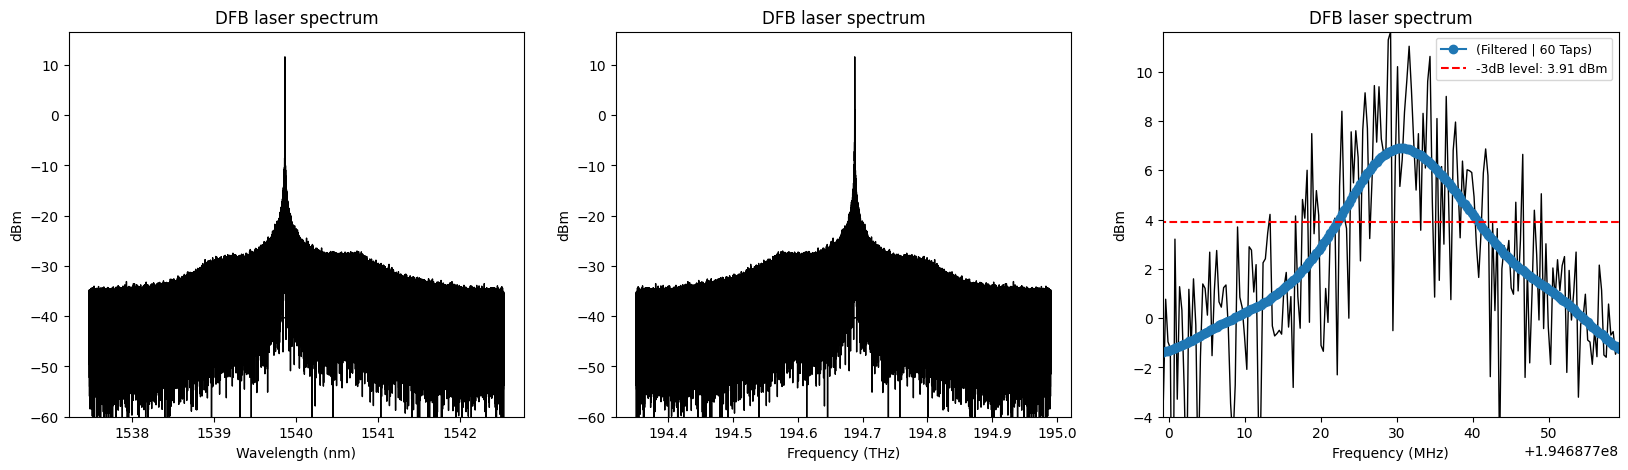

In [294]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

spectrum = np.abs(np.fft.fft(loadede_out,norm='forward'))
freq = np.fft.fftfreq(len(loadedt),d=1/Fs)
ax[0].plot(c/(freq+c/loadedlmbd)*1e9, 10*np.log10(1e3*spectrum), color='black',linewidth = 1)
# ax[0].set_xlim(1538,1542)
ax[0].set_ylim(-60,np.max(10*np.log10(1e3*spectrum))+5)
ax[0].set_ylabel('dBm')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_title('DFB laser spectrum')

spectrum = np.abs(np.fft.fft(loadede_out,norm='forward'))
freq = np.fft.fftfreq(len(loadedt),d=1/Fs)
ax[1].plot((freq+c/loadedlmbd)*1e-12, 10*np.log10(1e3*spectrum), color='black',linewidth = 1)
# ax[0].set_xlim(1538,1542)
ax[1].set_ylim(-60,np.max(10*np.log10(1e3*spectrum))+5)
ax[1].set_ylabel('dBm')
ax[1].set_xlabel('Frequency (THz)')
ax[1].set_title('DFB laser spectrum')

DeviationFreq = freq[np.argmax(spectrum)]
centerFreq = c/loadedlmbd + DeviationFreq
cutLims = [centerFreq - 1000e6 , centerFreq + 1000e6]

spectrum = np.concatenate((spectrum[int(len(freq)/2):],spectrum[:int(len(freq)/2)]))
freq = np.concatenate((freq[int(len(freq)/2):],freq[:int(len(freq)/2)]))
initFreq = int((cutLims[0]-freq[0]-(c/loadedlmbd))/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0]-(c/loadedlmbd))/(freq[-1]-freq[0])*len(freq))

freq = (freq+c/loadedlmbd)[initFreq:endFreq]
spectrum =  10*np.log10(1e3*spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 60
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

ax[2].plot(freq*1e-6, spectrum, color='black',linewidth = 1)
ax[2].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
ax[2].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
ax[2].set_xlim(centerFreq*1e-6 - 30 , centerFreq*1e-6 + 30)
ax[2].set_ylim(-4,np.max(spectrum)-0)
ax[2].set_ylabel('dBm')
ax[2].set_xlabel('Frequency (MHz)')
ax[2].set_title('DFB laser spectrum')
ax[2].legend(fontsize=9)

BestrightMark = 0
BestleftMark = 0

freq = freq[Ntaps:-Ntaps] 

for i in range(len(FilteredSpec)-1):
    if FilteredSpec[i+1] > np.max(FilteredSpec)-3 and FilteredSpec[i] <= np.max(FilteredSpec)-3:
        # print(f'leftMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(leftMark-centerFreq) <= np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] <= np.max(FilteredSpec)-3 and FilteredSpec[i] > np.max(FilteredSpec)-3:
        # print(f'rightMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(rightMark-centerFreq) <= np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
display(Math('Deviation~from~center~frequency = %5.6f~THz' %(DeviationFreq*1e-12)))
display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~Corrected~Linewidth~(/2) = %5.6f~MHz' %(delF,delF/2)))

## 50:50 Coupling and SMF 12km

The SMF parameters were gathered in the following references:
- [Corning-SMF-28E-Single-Mode-Bare-Fiber-Fiber-Optic-Center](https://focenter.com/media/wysiwyg/docs/Corning-Corning-SMF-28E-Single-Mode-Bare-Fiber-Fiber-Optic-Center.pdf) 
- [Nonlinear Fiber Optics - Govind P. Agrawal](https://www.sciencedirect.com/book/9780120451401/nonlinear-fiber-optics#:~:text=This%20book%20consists%20of%2010%20chapters%20and%20begins,in%20the%20field%20of%20fiber%20optics%20is%20provided.)

From the chapter 2 of "*Nonlinear Fiber Optics - Govind P. Agrawal*", the Fiber Nonlinear parameter ($\gamma$) can be calculated as: $$\gamma = \frac{n_2 \cdot \omega_0}{c \cdot A_{eff}}$$
and will result in $\approx 1.2~W^{-1}\cdot km^{-1}$ for 1540nm. Considering $n_2 \approx 2.36 \cdot 10^{-20}~m^2/W$ and $A_{eff} \approx 80 \cdot 10^{-12}~m^2$.

In [4]:
n2 = 2.36e-20
aeff = 80e-12
w0 = 2*np.pi*c/(1540e-9)

print(f'gamma = {n2*w0/(c*aeff)}')
print(w0)

gamma = 0.0012035971854662192
1223150368382372.0


In [6]:
KConst = 0.5         # Coupling Constant (0 to 1)
KPhase = (1/2)*np.pi   # Coupling Phase Delay between arms (rad)

SMFLen = 12          # Single Mode Fiber Length (km)
SMFAtt = 0.22        # Single Mode Fiber Attenuation (dB/km)
SMFGamma = 1.2       # Single Mode Fiber Nonlinear parameter (1/(W*km))
SMFDisp = 16         # Single Mode Fiber Chromatic Dispersion parameter (ps/nm/km)

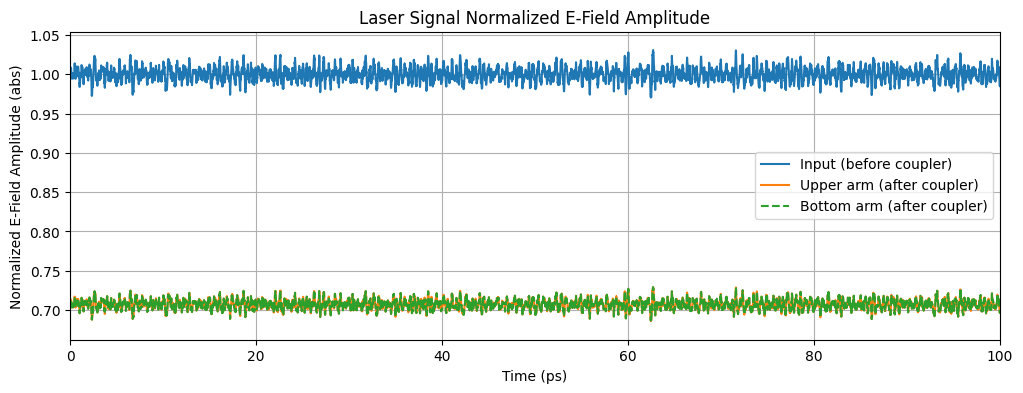

In [7]:
timeArray = np.linspace(0,Ts*bitsTx.size,SpS*bitsTx.size)

plt.figure(figsize=(12,4))

plt.plot(timeArray*1e12,np.abs(laser1.e_out)/np.mean(np.abs(laser1.e_out)), label='Input (before coupler)')
plt.plot(timeArray*1e12,np.abs(laser1.e_out*np.sqrt(KConst))/np.mean(np.abs(laser1.e_out)), label='Upper arm (after coupler)')
plt.plot(timeArray*1e12,np.abs(laser1.e_out*np.sqrt(1-KConst))/np.mean(np.abs(laser1.e_out)), label='Bottom arm (after coupler)', linestyle='--')
plt.xlim(0,100)
plt.xlabel('Time (ps)')
plt.ylabel('Normalized E-Field Amplitude (abs)')
plt.title('Laser Signal Normalized E-Field Amplitude')
plt.legend()
plt.grid()

Using the Split-Step Fourier Method (SSFM) for non-linear fibers (The Manakov model, considering that the PMD effects is much lower than the nonlinear effects), the nonlinear phase rotation step is given:
$$ E_x(z,t) \leftarrow \left[E_x(z,t) \exp \left[ -j8\gamma/9 \left( |E_x(z,t)|^2 + |E_y(z,t)|^2 \right) h_z \right]\right] $$
$$ E_y(z,t) \leftarrow \left[E_y(z,t) \exp \left[ -j8\gamma/9 \left( |E_x(z,t)|^2 + |E_y(z,t)|^2 \right) h_z \right]\right] $$

If we measure term $ \exp \left[ -j8\gamma/9 \left( |E_x(z,t)|^2 + |E_y(z,t)|^2 \right) h_z \right] $ using the obtained parameters of the E-Field (max value), SMF length and the Fiber Nonlinear parameter ($\gamma$), we get:


In [9]:
hz = 0.1  # Horizontal step in km
PhaseRotation = (np.max(np.abs(np.real(laser1.e_out)))*np.sqrt(KConst))**2 * SMFGamma * (8/9) * hz
display(Math('Phase~Rotation:~~~~~~From~one~step = %5.6f ~rad ~~~|~~~ From~all~steps~summed = %5.6f ~rad' %(PhaseRotation,PhaseRotation*SMFLen/hz)))

<IPython.core.display.Math object>

This value is considerable low, so it is justified the use of a *Linear Fiber Model*. No Y polarization was considered in this case.

In [10]:
LinearFiber_parameters = parameters()
LinearFiber_parameters.L = SMFLen           # [km] total fiber length
LinearFiber_parameters.alpha = SMFAtt       # [dB/km] fiber attenuation parameter 
LinearFiber_parameters.D = SMFDisp          # [ps/nm/km] chromatic dispersion parameter
LinearFiber_parameters.Fc = c/laser1.lmbd   # [Hz] carrier frequency
LinearFiber_parameters.Fs = Fs              # [Hz] sampling frequency 

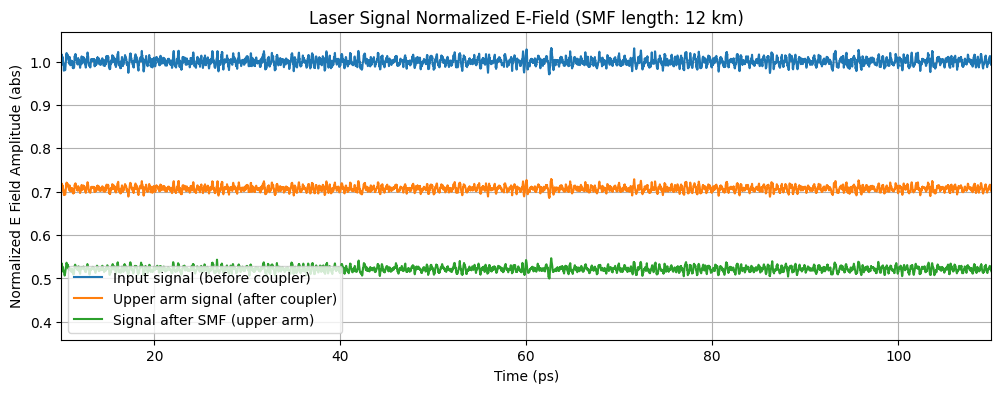

In [11]:
EUpper = linearFiberChannel(laser1.e_out*np.sqrt(KConst),LinearFiber_parameters)  

timeArray = np.linspace(0,Ts*bitsTx.size,SpS*bitsTx.size)

plt.figure(figsize=(12,4))

plt.plot(timeArray*1e12,np.abs(laser1.e_out)/np.mean(np.abs(laser1.e_out)),label='Input signal (before coupler)')
plt.plot(timeArray*1e12,np.abs(laser1.e_out*np.sqrt(KConst))/np.mean(np.abs(laser1.e_out)),label='Upper arm signal (after coupler)')
plt.plot(timeArray*1e12,np.abs(EUpper)/np.mean(np.abs(laser1.e_out)), label='Signal after SMF (upper arm)')
plt.xlim(10,110)
# plt.ylim(np.min(np.real(laser1.e_out)),np.max(np.real(laser1.e_out)))
plt.xlabel('Time (ps)')
plt.ylabel('Normalized E Field Amplitude (abs)')
plt.title(f'Laser Signal Normalized E-Field (SMF length: {SMFLen} km)')
plt.legend()
plt.grid()

The graph above don't consider the group delay $\tau$ caused by the fiber

## Phase Modulation (bottom arm) and Photodiode detection

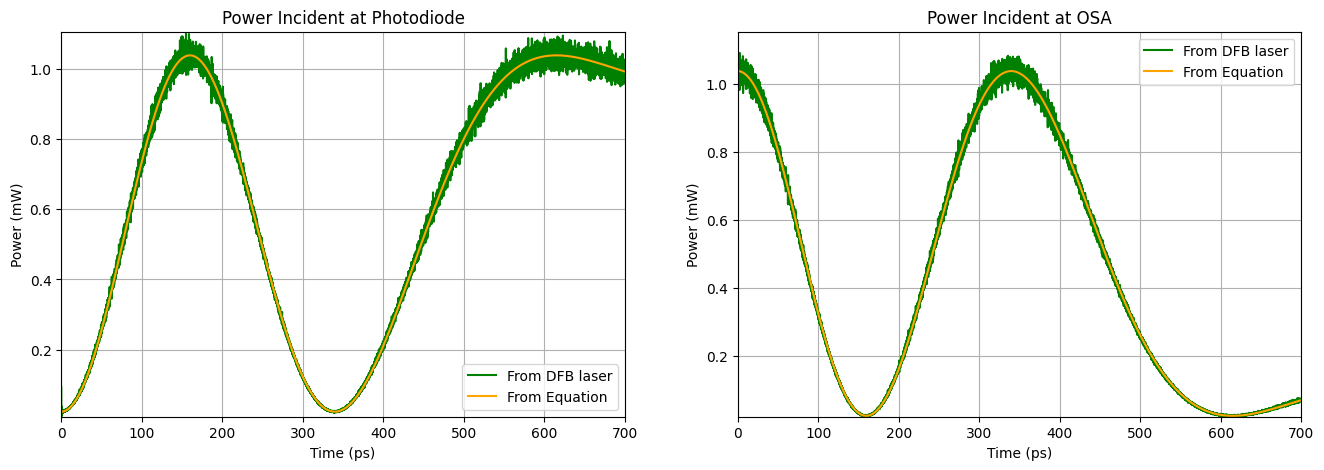

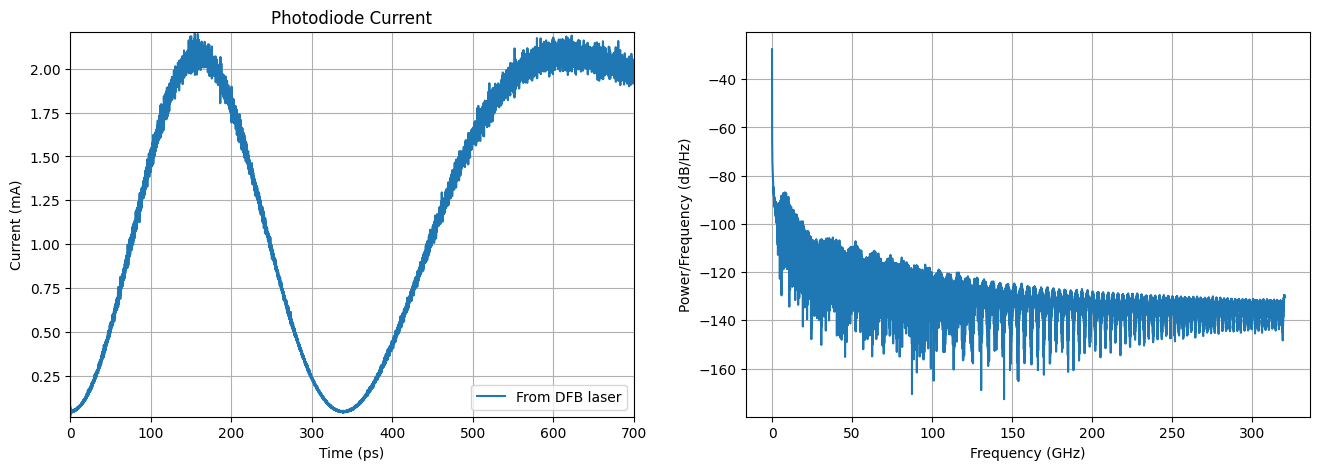

In [13]:
carrier = laser1.e_out*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
b = 10           # Modulation index of the electrical modulating signal
mFreq = 2e9     # Frequency of the electrical modulating signal (Hz)
mPhase = 0      # Phase of the electrical modulating signal (Radians)
R = 1           # Photodiode Responsivity

EBottom = carrier*np.exp(1j*b*np.sin(mFreq*timeArray+mPhase))

Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

# Model equations -------------------------------------------------------------

meanPower = np.mean(laser1.power)
EUppermodel = np.sqrt(KConst)*np.sqrt(meanPower)*np.exp(1j*(2*np.pi*EffFreqDeviation*1e9)*timeArray)/np.sqrt((10)**(SMFAtt*SMFLen/10))
EBottommodel = np.sqrt(1-KConst)*np.sqrt(meanPower)*np.exp(1j*(2*np.pi*EffFreqDeviation*1e9)*timeArray)*np.exp(KPhase*1j)*np.exp(1j*b*np.sin(mFreq*timeArray+mPhase))
Emodelpd = KConst*EUppermodel + (1-KConst)*np.exp(1j*KPhase)*EBottommodel
Emodelosa = (1-KConst)*np.exp(1j*KPhase)*EUppermodel + KConst*EBottommodel

# Post-Photodiode -------------------------------------------------------------

IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode

fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(16)

ax[0].plot(timeArray*1e12,np.abs(Epd)**2*1e3, label='From DFB laser',color='green')
ax[0].plot(timeArray*1e12,np.abs(Emodelpd)**2*1e3, label='From Equation',color='orange')
ax[0].set_xlim(0,700)
ax[0].set_ylim(np.min(np.abs(Epd)**2)*1e3,np.max(np.abs(Epd)**2)*1e3)
ax[0].set_xlabel('Time (ps)')
ax[0].set_ylabel('Power (mW)')
ax[0].set_title('Power Incident at Photodiode')
ax[0].grid()
ax[0].legend()

ax[1].plot(timeArray*1e12,np.abs(Eosa)**2*1e3, label='From DFB laser',color='green')
ax[1].plot(timeArray*1e12,np.abs(Emodelosa)**2*1e3, label='From Equation',color='orange')
ax[1].set_xlim(0,700)
ax[1].set_ylim(np.min(np.abs(Eosa)**2)*1e3,np.max(np.abs(Eosa)**2)*1e3)
ax[1].set_xlabel('Time (ps)')
ax[1].set_ylabel('Power (mW)')
ax[1].set_title('Power Incident at OSA')
ax[1].grid()
ax[1].legend()

fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(16)

ax[0].plot(timeArray*1e12,IPd*1e3, label='From DFB laser')
# ax[0].plot(timeArray*1e12,np.abs(Emodelpd)**2*1e3, label='From Equation')
ax[0].set_xlim(0,700)
ax[0].set_ylim(np.min(IPd)*1e3,np.max(IPd)*1e3)
ax[0].set_xlabel('Time (ps)')
ax[0].set_ylabel('Current (mA)')
ax[0].set_title('Photodiode Current')
ax[0].grid()
ax[0].legend()

freq, spectrum = get_spectrum(IPd, Fs=Fs, Fc=0, xunits='hz',sides='onesided')
ax[1].plot(freq*1e-9,spectrum)
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1].grid()

# Heavy Simulation 

In [ ]:
laser_dfb_parameters = parameters()
laser_dfb_parameters.noise_terms = True
laser_dfb_parameters.v       = 1.0       # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 0.33e-9   # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.50e-6   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 4.52e+9   # [cm/s] group velocity
laser_dfb_parameters.n_t     = 8.2e6     # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 4.58e-8   # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 7.15e-12  # [s] photon lifetime
laser_dfb_parameters.gamma   = 1.0       # mode confinement factor
laser_dfb_parameters.beta    = 3.54e-5   # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 11.55      # linewidth enchancement factor (default is 1.55)
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.0129    # [A] i_bias
laser_dfb_parameters.i_max   = 0.0300    # [A] i_max
laser_dfb_parameters.eta_0   = 0.21      # total differential quantum efficiency
laser_dfb_parameters.lmbd    = 1540e-9   # [m] wavelength

In [3]:
# simulation parameters
SpS = 64    # Samples per Symbol
Rs = 330e6  # Symbol rate (for OOK case Rs = Rb)

Tsymb = 1/Rs       # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.ones(2**14)
n = np.arange(0, bitsTx.size)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting (not necessary for CW operation)
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])  # Shifts the signal to the right and fill the new created empty values with a constant = cval 
t = np.arange(0,SpS*len(bitsTx))*Ts

SMFLen = 12          # Single Mode Fiber Length (km)
tau = SMFLen/(c*1e-3)    # Fiber Delay


print(f'Samples: {SpS*len(bitsTx)} |  Discounting the delay: {SpS*len(bitsTx)*(SpS*len(bitsTx)*Ts-tau)/(SpS*len(bitsTx)*Ts)}')
print(f'Total sample time: {SpS*len(bitsTx)*Ts*1e6} us  |  Discounting the delay: {(SpS*len(bitsTx)*Ts-tau)*1e6} us')
print(f'Sampling period: {Ts*1e12} ps')
print(f'Sampling frequency: {Fs*1e-9} Gsample/s')

Samples: 1048576 |  Discounting the delay: 203191.15712980347
Total sample time: 49.64848484848485 us  |  Discounting the delay: 9.620793424706605 us
Sampling period: 47.34848484848485 ps
Sampling frequency: 21.12 Gsample/s


In [ ]:
laser_dfb_parameters.noise_terms = True
laser1 = laser_dfb(laser_dfb_parameters)
sol = laser1.solve(t, sigTx)

picklepath = 'Data/'
checkpoint_count = sum(len(files) for _, _, files in os.walk(picklepath))
SaveFile = {}

SaveFile['N'] = laser1.N
SaveFile['S'] = laser1.S
SaveFile['phase'] = laser1.phase
SaveFile['power'] = laser1.power
SaveFile['chirp'] = laser1.chirp
SaveFile['e_out'] = laser1.e_out
SaveFile['current'] = laser1.current
SaveFile['t'] = laser1.t
SaveFile['lmbd'] = laser1.lmbd
SaveFile['SpS'] = SpS
SaveFile['Rs'] = Rs
with open(picklepath+'Dataset('+str(checkpoint_count+1)+').pickle','wb') as handle:
    pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)

Solving ODEs... Showing steps taken (compared to t_eval):   0%|          | 0/1048576 [00:00<?, ?it/s]

## Load Data

In [85]:
LoadData = 4

picklepath = 'Data/'

with open(picklepath+'Dataset('+str(LoadData)+').pickle','rb') as handle:
    LoadFile = pickle.load(handle)

loadedN = LoadFile['N']
loadedS = LoadFile['S']
loadedphase = LoadFile['phase']
loadedpower = LoadFile['power']
loadedchirp = LoadFile['chirp']
loadede_out = LoadFile['e_out']
loadedcurrent = LoadFile['current']
loadedt = LoadFile['t']
loadedlmbd = LoadFile['lmbd']
loadedsps = LoadFile['SpS']
loadedrs = LoadFile['Rs']

print(f'Dataset {LoadData} loaded')

Tsymb = 1/loadedrs       # Symbol period in seconds
Fs = 1/(Tsymb/loadedsps) # Signal sampling frequency (samples/second)
Ts = 1/Fs          # Sampling period

print(f'Samples: {len(loadedt)}')
print(f'Total sample time: {len(loadedt)*Ts*1e6} us')
print(f'Sampling period: {Ts*1e12} ps')
print(f'Sampling frequency: {Fs*1e-9} Gsample/s')

Dataset 4 loaded
Samples: 2097152
Total sample time: 99.2969696969697 us
Sampling period: 47.34848484848485 ps
Sampling frequency: 21.12 Gsample/s


In [86]:
KConst = 0.5         # Coupling Constant (0 to 1)
KPhase = (1/2)*np.pi   # Coupling Phase Delay between arms (rad)

SMFLen = 12          # Single Mode Fiber Length (km)
SMFAtt = 0.22        # Single Mode Fiber Attenuation (dB/km)
SMFGamma = 1.2       # Single Mode Fiber Nonlinear parameter (1/(W*km))
SMFDisp = 16         # Single Mode Fiber Chromatic Dispersion parameter (ps/nm/km)
tau = SMFLen/(c*1e-3)    # Fiber Delay

bIdx = 2.63           # Modulation index of the electrical modulating signal
mFreq = 2e9     # Frequency of the electrical modulating signal (Hz)
mPhase = 0      # Phase of the electrical modulating signal (Radians)
R = 1           # Photodiode Responsivity

In [74]:
print(c*1e-12/loadedlmbd)

194.67042727272727


19859
BestleftMark: 194678946.70815763 MHz
BestrightMark: 194678956.05319774 MHz


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

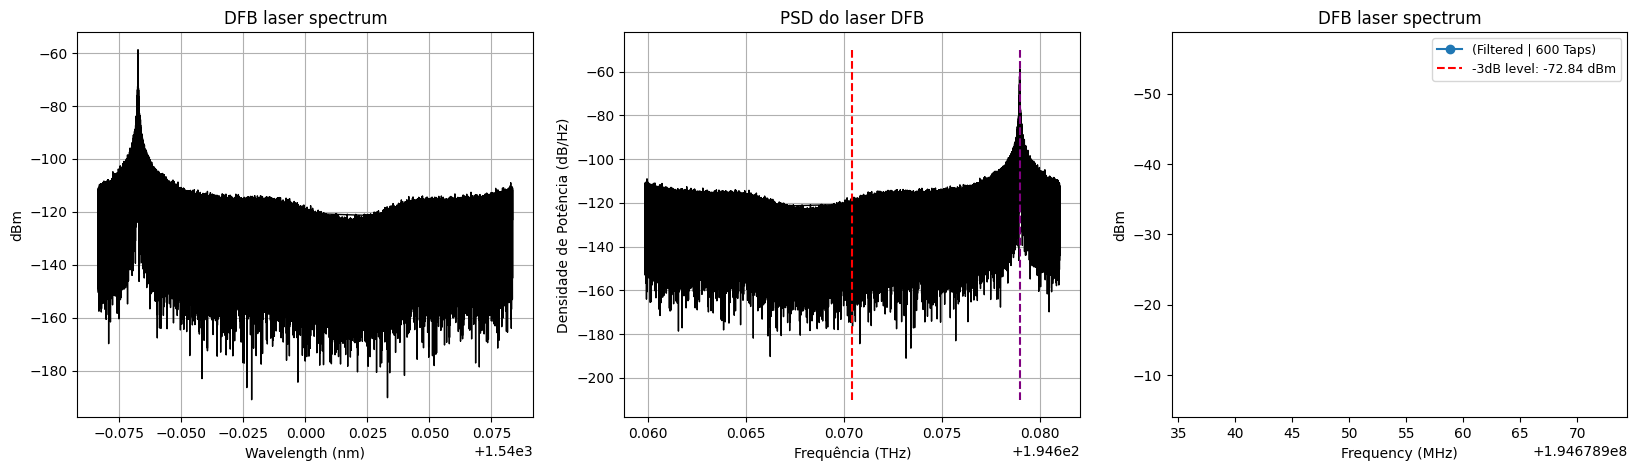

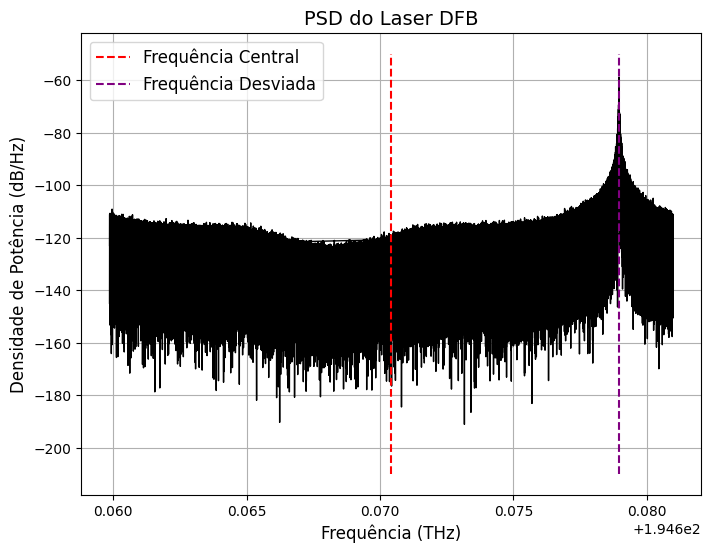

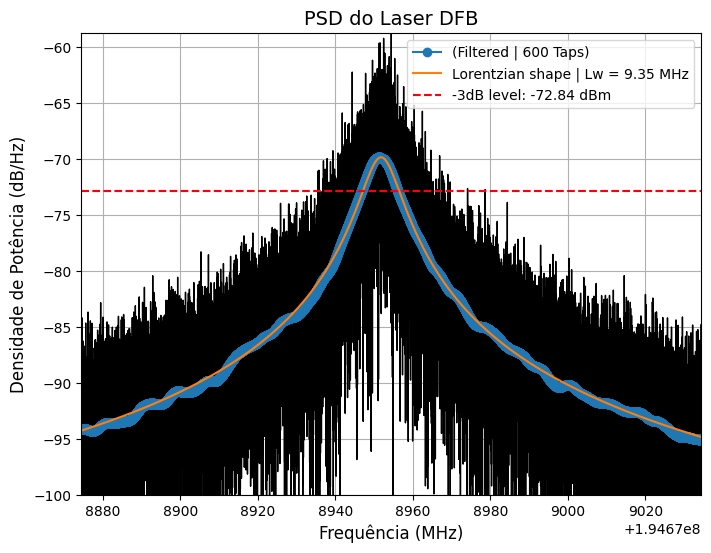

In [87]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

spectrum = len(loadede_out)*np.abs(np.fft.fft(loadede_out,norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(loadedt),d=1/Fs)
ax[0].plot(c/(freq+c/loadedlmbd)*1e9, 10*np.log10(1e3*spectrum), color='black',linewidth = 1)
# ax[0].set_xlim(1538,1542)
# ax[0].set_ylim(-60,np.max(10*np.log10(1e3*spectrum))+5)
ax[0].set_ylabel('dBm')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_title('DFB laser spectrum')
ax[0].grid()

DeviationFreq = freq[np.argmax(spectrum)]

spectrum = len(loadede_out)*np.abs(np.fft.fft(loadede_out,norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(loadedt),d=1/Fs)
ax[1].plot((freq+c/loadedlmbd)*1e-12, 10*np.log10(1e3*spectrum), color='black',linewidth = 1)
ax[1].vlines((c/loadedlmbd)*1e-12,ymin=-210, ymax=-50, color='red', linestyle='--', label=f'Frequência Central')
ax[1].vlines(((c/loadedlmbd)+DeviationFreq)*1e-12,ymin=-210, ymax=-50, color='purple', linestyle='--', label=f'Frequência Desviada')
# ax[0].set_xlim(1538,1542)
# ax[1].set_ylim(-60,np.max(10*np.log10(1e3*spectrum))+5)
ax[1].set_ylabel('Densidade de Potência (dB/Hz)')
ax[1].set_xlabel('Frequência (THz)')
ax[1].set_title('PSD do laser DFB')
ax[1].grid()

centerFreq = c/loadedlmbd + DeviationFreq
cutLims = [centerFreq - 100e6 , centerFreq + 100e6]

spectrum = np.concatenate((spectrum[int(len(freq)/2):],spectrum[:int(len(freq)/2)]))
freq = np.concatenate((freq[int(len(freq)/2):],freq[:int(len(freq)/2)]))
initFreq = int((cutLims[0]-freq[0]-(c/loadedlmbd))/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0]-(c/loadedlmbd))/(freq[-1]-freq[0])*len(freq))

freq = (freq+c/loadedlmbd)[initFreq:endFreq]
spectrum =  10*np.log10(1e3*spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 600
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
print(len(spectrum))
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

ax[2].plot(freq*1e-6, spectrum, color='black',linewidth = 1)
ax[2].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
ax[2].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
ax[2].set_xlim(centerFreq*1e-6 - 20 , centerFreq*1e-6 + 20)
ax[2].set_ylim(-4,np.max(spectrum)-0)
ax[2].set_ylabel('dBm')
ax[2].set_xlabel('Frequency (MHz)')
ax[2].set_title('DFB laser spectrum')
ax[2].legend(fontsize=9)

BestrightMark = 0
BestleftMark = 0

freq = freq[Ntaps:-Ntaps] 

for i in range(len(FilteredSpec)-1):
    if FilteredSpec[i+1] > np.max(FilteredSpec)-3 and FilteredSpec[i] <= np.max(FilteredSpec)-3:
        # print(f'leftMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(leftMark-centerFreq) <= np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] <= np.max(FilteredSpec)-3 and FilteredSpec[i] > np.max(FilteredSpec)-3:
        # print(f'rightMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(rightMark-centerFreq) <= np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
EffFreqDeviation = np.round((loadedphase[-1]-loadedphase[0])/(2*np.pi*loadedt[-1]),3)
display(Math('Deviation~from~center~frequency = %5.6f~THz~(Highest~Power~Bin)' %(DeviationFreq*1e-12)))
display(Math('Deviation~from~center~frequency = %5.6f~THz~(Insntantaneous~Freq)' %(EffFreqDeviation*1e-12)))
display(Math('Measured~Linewidth = %5.6f~MHz' %(delF)))


spectrumshow = len(loadede_out)*np.abs(np.fft.fft(loadede_out,norm='forward'))**2/Fs
freqshow = np.fft.fftfreq(len(loadedt),d=1/Fs)
plt.figure(figsize=(8,6))
plt.plot((freqshow+c/loadedlmbd)*1e-12, 10*np.log10(1e3*spectrumshow), color='black',linewidth = 1)
plt.vlines((c/loadedlmbd)*1e-12,ymin=-210, ymax=-50, color='red', linestyle='--', label=f'Frequência Central')
plt.vlines(((c/loadedlmbd)+DeviationFreq)*1e-12,ymin=-210, ymax=-50, color='purple', linestyle='--', label=f'Frequência Desviada')
plt.ylabel('Densidade de Potência (dB/Hz)',fontsize=12)
plt.xlabel('Frequência (THz)',fontsize=12)
plt.title('PSD do Laser DFB',fontsize=14)
plt.grid()
plt.legend(fontsize=12)
# plt.savefig("FreqDeviationDFB.pdf", format="pdf")


# Comparison with a lorentzian shape ---------------------------------------------------

f0 = c/loadedlmbd + EffFreqDeviation
delV = delF*1e6
LorentzS = 10*np.log10(1/(2*np.pi) * delV/((freq - f0)**2 + (delV/2)**2))
LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))

plt.figure(figsize=(8,6))
plt.plot(freq*1e-6, spectrum[Ntaps:-Ntaps], color='black',linewidth = 1)
plt.plot(freq*1e-6,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
plt.plot(freq*1e-6,LorentzS,label=f'Lorentzian shape | Lw = {np.round(delV*1e-6,2)} MHz')
plt.hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
plt.xlim(centerFreq*1e-6 - 80 , centerFreq*1e-6 + 80)
plt.ylim(-100,np.max(spectrum)+0)
plt.ylabel('Densidade de Potência (dB/Hz)',fontsize=12)
plt.xlabel('Frequência (MHz)',fontsize=12)
plt.title('PSD do Laser DFB',fontsize=14)
plt.grid()
plt.legend(fontsize=10)
plt.savefig("DFBPSD.pdf", format="pdf")

## Photodiode Current and PSD visualization

c:\Users\Caio\Documents\GitHub\Laser-Study\.venv\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Caio\Documents\GitHub\Laser-Study\.venv\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


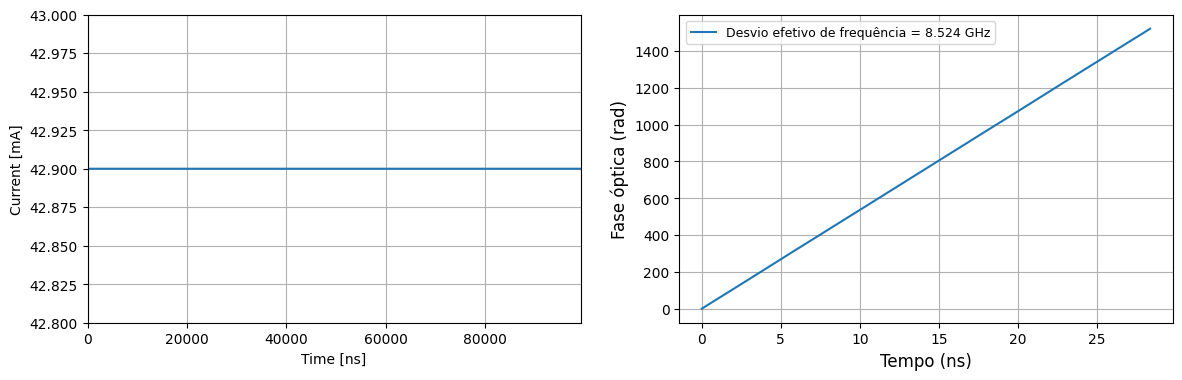

In [88]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(14)

ax[0].plot(1e9*loadedt, 1e3*loadedcurrent)
ax[0].set_xlabel('Time [ns]')
ax[0].set_ylabel('Current [mA]')
ax[0].set_xlim([1e9*loadedt.min(), 1e9*loadedt.max()])
ax[0].set_ylim([42.8,43])
ax[0].grid(True)

EffFreqDeviation = np.round(1e-9*(loadedphase[-1]-loadedphase[0])/(2*np.pi*loadedt[-1]),3)
ax[1].plot(1e9*loadedt[:600], loadedphase[:600]-loadedphase[0], label=f'Desvio efetivo de frequência = {EffFreqDeviation} GHz')
ax[1].set_xlabel('Tempo (ns)',fontsize=12)
ax[1].set_ylabel('Fase óptica (rad)',fontsize=12)
# ax[1].set_xlim([0,1])
# ax[1].set_ylim([0,7])
ax[1].legend(fontsize=9)
ax[1].grid(True)

plt.savefig("EffectiveFreqDeviation.pdf", format="pdf")

The SMF delay on the upper arm is now included

In [89]:
LinearFiber_parameters = parameters()
LinearFiber_parameters.L = SMFLen           # [km] total fiber length
LinearFiber_parameters.alpha = SMFAtt       # [dB/km] fiber attenuation parameter 
LinearFiber_parameters.D = SMFDisp          # [ps/nm/km] chromatic dispersion parameter
LinearFiber_parameters.Fc = c/loadedlmbd  # [Hz] carrier frequency
LinearFiber_parameters.Fs = Fs              # [Hz] sampling frequency 

tau = SMFLen/(c*1e-3)    # Fiber Delay
shiftValue = int(len(loadedt)*tau/loadedt[-1])
print(f'SMF Delay = {tau*1e6} us')

EUpper = linearFiberChannel(loadede_out*np.sqrt(KConst),LinearFiber_parameters)  
EUpper = shift(EUpper,shiftValue,cval=EUpper[0])
EUpper = EUpper[shiftValue:]

carrier = loadede_out*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
EBottom = carrier*np.exp(1j*bIdx*np.sin(2*np.pi*mFreq*loadedt+mPhase))
EBottom = EBottom[shiftValue:]

timeArray = loadedt[shiftValue:]

print(f'EUpper len: {len(EUpper)} | EBottom len: {len(EBottom)} | TimeArray len: {len(timeArray)} ')

Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode


EffFreqDeviation = np.round((loadedphase[-1]-loadedphase[0])/(2*np.pi*loadedt[-1]),3)
meanPower = np.mean(loadedpower)
EUppermodel = np.sqrt(KConst)*np.sqrt(meanPower)*np.exp(1j*(2*np.pi*EffFreqDeviation*loadedt+np.pi/2))/np.sqrt((10)**(SMFAtt*SMFLen/10))
EUppermodel = shift(EUppermodel,shiftValue,cval=EUppermodel[0])
EUppermodel = EUppermodel[shiftValue:]

EBottommodel = np.sqrt(1-KConst)*np.sqrt(meanPower)*np.exp(1j*(2*np.pi*EffFreqDeviation*loadedt+np.pi/2))*np.exp(KPhase*1j)*np.exp(1j*bIdx*np.sin(2*np.pi*mFreq*loadedt+mPhase))
EBottommodel = EBottommodel[shiftValue:]

print(f'EUpperEquation len: {len(EUppermodel)} | EBottomEquation len: {len(EBottommodel)}')

Emodelpd = KConst*EUppermodel + (1-KConst)*np.exp(1j*KPhase)*EBottommodel
Emodelosa = (1-KConst)*np.exp(1j*KPhase)*EUppermodel + KConst*EBottommodel

SMF Delay = 40.02769142377824 us
EUpper len: 1251767 | EBottom len: 1251767 | TimeArray len: 1251767 
EUpperEquation len: 1251767 | EBottomEquation len: 1251767


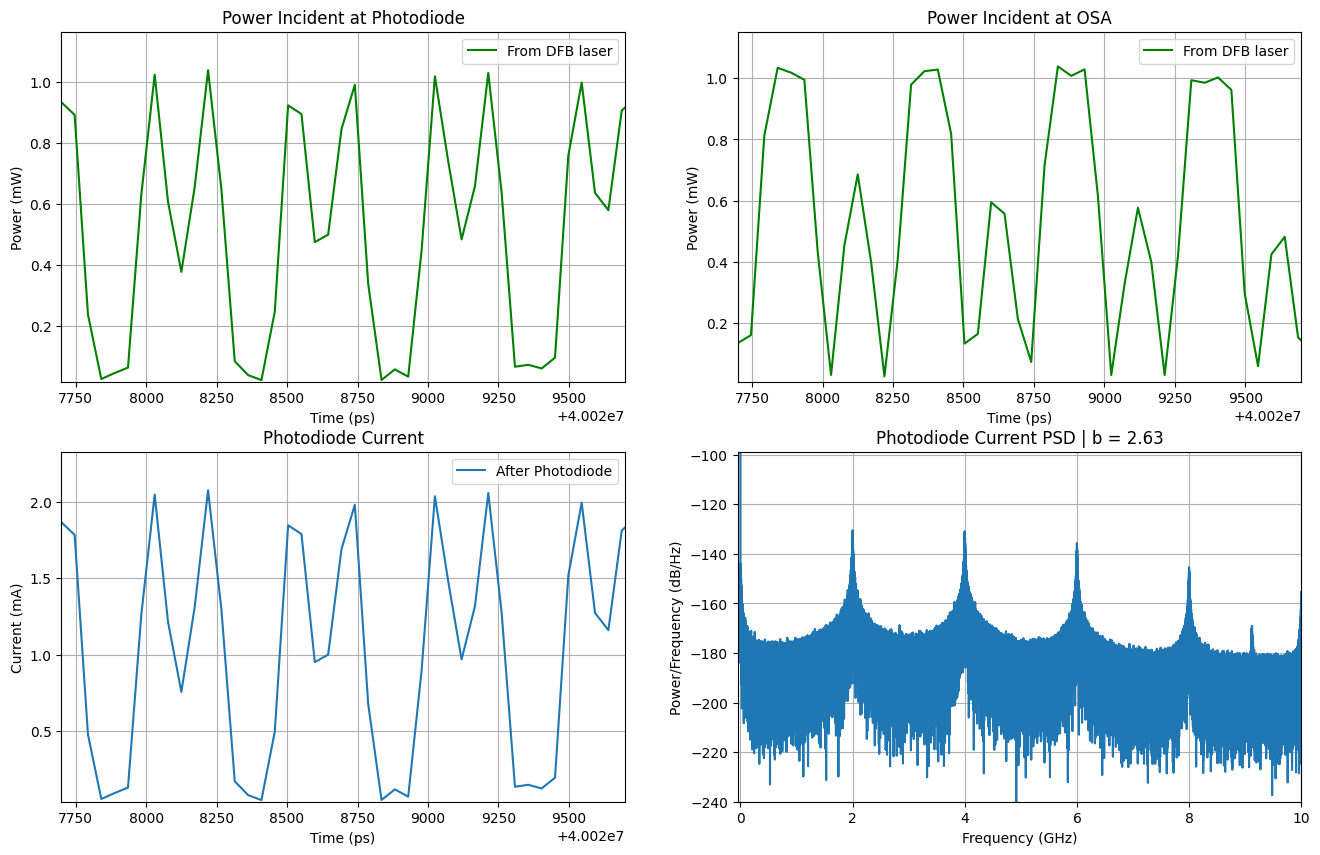

In [45]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(16)

StTime = np.min(timeArray*1e12) # Starting time post delay

ax[0][0].plot(timeArray*1e12,np.abs(Epd)**2*1e3, label='From DFB laser',color='green')
# ax[0][0].plot(timeArray*1e12,np.abs(Emodelpd)**2*1e3, label='From Equation',color='orange',linestyle='--')
ax[0][0].set_xlim(StTime,StTime+2000)
ax[0][0].set_ylim(np.min(np.abs(Epd)**2)*1e3,np.max(np.abs(Epd)**2)*1e3)
ax[0][0].set_xlabel('Time (ps)')
ax[0][0].set_ylabel('Power (mW)')
ax[0][0].set_title('Power Incident at Photodiode')
ax[0][0].grid()
ax[0][0].legend()

ax[0][1].plot(timeArray*1e12,np.abs(Eosa)**2*1e3, label='From DFB laser',color='green')
# ax[0][1].plot(timeArray*1e12,np.abs(Emodelosa)**2*1e3, label='From Equation',color='orange',linestyle='--')
ax[0][1].set_xlim(StTime,StTime+2000)
ax[0][1].set_ylim(np.min(np.abs(Eosa)**2)*1e3,np.max(np.abs(Eosa)**2)*1e3)
ax[0][1].set_xlabel('Time (ps)')
ax[0][1].set_ylabel('Power (mW)')
ax[0][1].set_title('Power Incident at OSA')
ax[0][1].grid()
ax[0][1].legend()

ax[1][0].plot(timeArray*1e12,IPd*1e3, label='After Photodiode')
# ax[1][0].plot(timeArray*1e12,np.abs(Emodelpd)**2*1e3, label='From Equation')
ax[1][0].set_xlim(StTime,StTime+2000)
ax[1][0].set_ylim(np.min(IPd)*1e3,np.max(IPd)*1e3)
ax[1][0].set_xlabel('Time (ps)')
ax[1][0].set_ylabel('Current (mA)')
ax[1][0].set_title('Photodiode Current')
ax[1][0].grid()
ax[1][0].legend()

# freq, spectrum = get_spectrum(IPd, Fs=Fs, Fc=0, xunits='hz',sides='onesided')
spectrum = len(IPd)*np.abs(np.fft.fft(IPd, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(IPd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

ax[1][1].plot(freq*1e-9,10*np.log10(spectrum))
ax[1][1].set_xlabel('Frequency (GHz)')
ax[1][1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1][1].set_xlim(-0.05,10)
ax[1][1].set_ylim(-240,np.max(10*np.log10(spectrum)))
ax[1][1].set_title(f'Photodiode Current PSD | b = {bIdx}')
ax[1][1].grid()

In [46]:
DeviationFreq*1e-12

0.005904299011230469

BestleftMark: 1991.1462732082248 MHz
BestrightMark: 2009.4016116676623 MHz
BestleftMark2: 1992.1842748094116 MHz
BestrightMark2: 2002.4048710498503 MHz


<IPython.core.display.Math object>

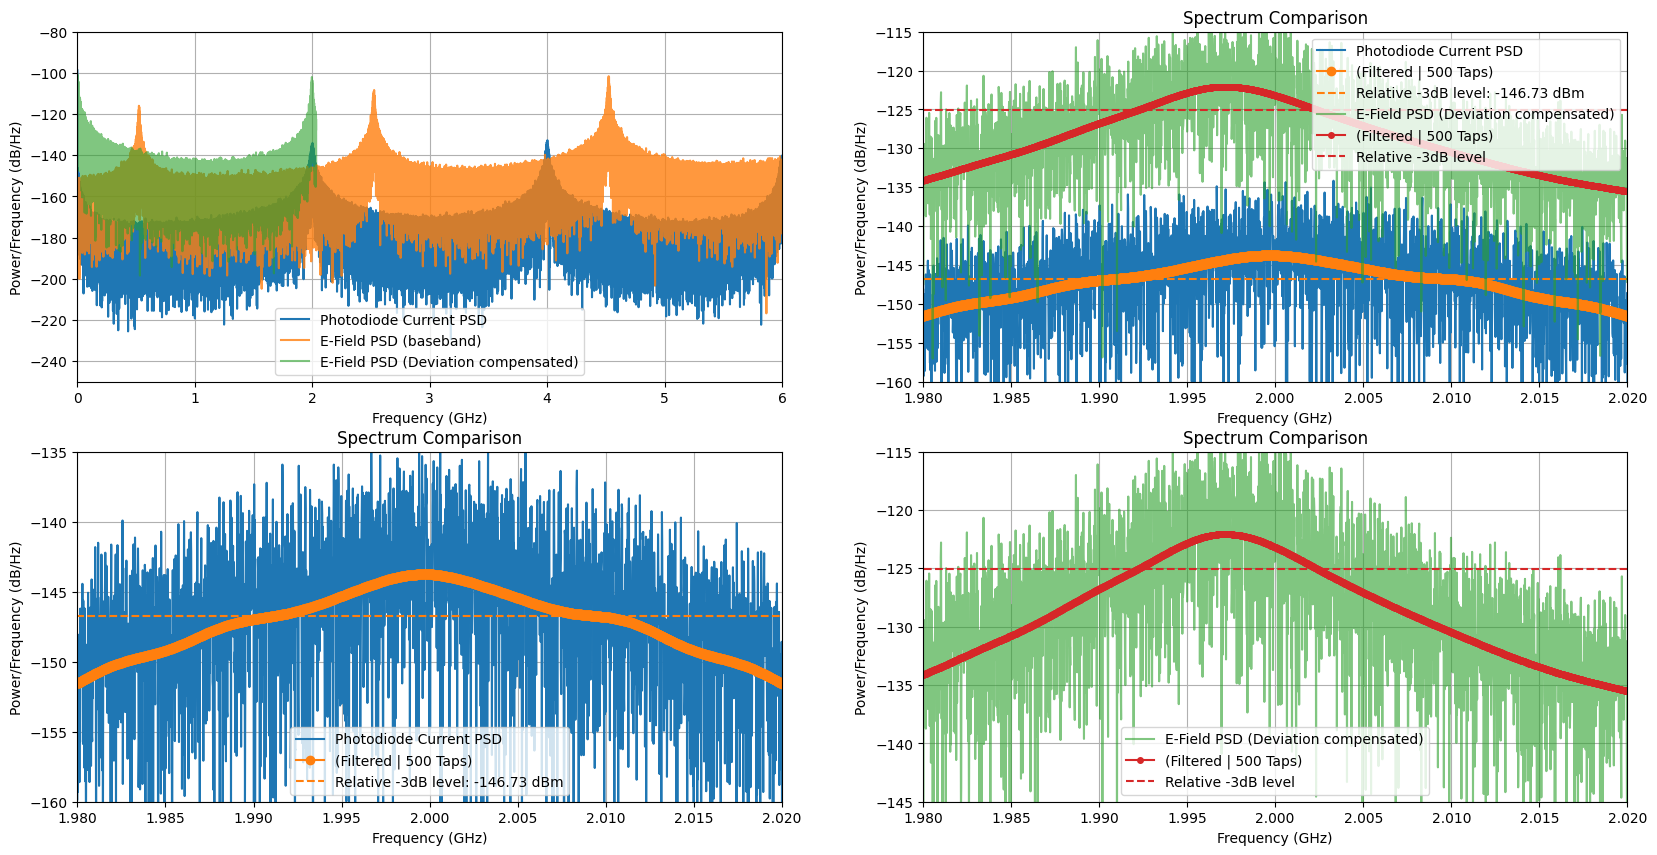

In [10]:
spectrum = len(IPd)*np.abs(np.fft.fft(IPd, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(IPd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

spectrum2 = len(Epd)*np.abs(np.fft.fft(Epd, norm='forward'))**2/Fs
freq2 = np.fft.fftfreq(len(Epd),d=1/Fs)
spectrum2 = 2*spectrum2[:int(len(freq2)/2)]
freq2 = freq2[:int(len(freq2)/2)]

spectrumDiff = 10*(np.max(np.log10(spectrum2))-np.max(np.log10(spectrum))) + 8

fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(20)

ax[0][0].plot(freq*1e-9,10*np.log10(spectrum), label='Photodiode Current PSD')
ax[0][0].plot((freq2)*1e-9,10*np.log10(spectrum2), label='E-Field PSD (baseband)',alpha=0.8)
ax[0][0].plot((freq2-DeviationFreq)*1e-9,10*np.log10(spectrum2), label='E-Field PSD (Deviation compensated)',alpha=0.6)
ax[0][0].set_xlabel('Frequency (GHz)')
ax[0][0].set_ylabel('Power/Frequency (dB/Hz)')
ax[0][0].set_xlim(2-2,2+4)
ax[0][0].set_ylim(-250,-80)
ax[0][0].legend()
ax[0][0].grid()


# Linewidth calculation ------------------------------------------------------------------------------------------

spectrum = len(IPd)*np.abs(np.fft.fft(IPd, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(IPd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

spectrum2 = len(Epd)*np.abs(np.fft.fft(Epd, norm='forward'))**2/Fs
freq2 = np.fft.fftfreq(len(Epd),d=1/Fs)-DeviationFreq
spectrum2 = 2*spectrum2[:int(len(freq2)/2)]
freq2 = freq2[:int(len(freq2)/2)]

Ntaps = 500
Ntaps2 = 500
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
b2 = signal.firwin(numtaps = Ntaps2, cutoff = 1e-5, window='hamming')
peakFreq = 2e9

centerFreq = peakFreq 
cutLims = [centerFreq - 50e6 , centerFreq + 50e6]

centerFreq2 = peakFreq
cutLims2 = [centerFreq2 - 50e6 , centerFreq2 + 50e6]

initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

initFreq2 = int((cutLims2[0]-freq2[0])/(freq2[-1]-freq2[0])*len(freq2))
endFreq2 = int((cutLims2[1]-freq2[0])/(freq2[-1]-freq2[0])*len(freq2))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(spectrum[initFreq:endFreq])
freq2 = freq2[initFreq2:endFreq2]
spectrum2 =  10*np.log10(spectrum2[initFreq2:endFreq2])

FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  
FilteredSpec2 = firFilter(b2, spectrum2)[Ntaps2:-Ntaps2]  

BestrightMark = 0
BestleftMark = 0
BestrightMark2 = 0
BestleftMark2 = 0

freq = freq[Ntaps:-Ntaps] 
freq2 = freq2[Ntaps2:-Ntaps2] 
spectrum = spectrum[Ntaps:-Ntaps] 
spectrum2 = spectrum2[Ntaps2:-Ntaps2] 

for i in range(len(FilteredSpec)-1):
    if FilteredSpec[i+1] > np.max(FilteredSpec)-3 and FilteredSpec[i] <= np.max(FilteredSpec)-3:
        # print(f'leftMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(leftMark-centerFreq) <= np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] <= np.max(FilteredSpec)-3 and FilteredSpec[i] > np.max(FilteredSpec)-3:
        # print(f'rightMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(rightMark-centerFreq) <= np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

for i in range(len(FilteredSpec2)-1):
    if FilteredSpec2[i+1] > np.max(FilteredSpec2)-3 and FilteredSpec2[i] <= np.max(FilteredSpec2)-3:
        # print(f'leftMark between {np.round(freq2[i]*1e-6,2)} and {np.round(freq2[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec2)-3-FilteredSpec2[i])/(FilteredSpec2[i+1]-FilteredSpec2[i]) * (freq2[i+1]-freq2[i]) + freq2[i]
        if (np.abs(leftMark-centerFreq2) <= np.abs(BestleftMark2-centerFreq2) and leftMark < centerFreq2):
            BestleftMark2 = leftMark
            print(f'BestleftMark2: {BestleftMark2*1e-6} MHz')
    elif FilteredSpec2[i+1] <= np.max(FilteredSpec2)-3 and FilteredSpec2[i] > np.max(FilteredSpec2)-3:
        # print(f'rightMark between {np.round(freq2[i]*1e-6,2)} and {np.round(freq2[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec2)-3-FilteredSpec2[i])/(FilteredSpec2[i+1]-FilteredSpec2[i]) * (freq2[i+1]-freq2[i]) + freq2[i]
        if (np.abs(rightMark-centerFreq2) <= np.abs(BestrightMark2-centerFreq2) and rightMark > centerFreq2):
            BestrightMark2 = rightMark
            print(f'BestrightMark2: {BestrightMark2*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
delF2 = BestrightMark2*1e-6-BestleftMark2*1e-6
display(Math('PD~Current~Linewidth(/2) = %5.6f~MHz~~|~~E-Field~Linewidth = %5.6f~MHz' %(delF/2, delF2)))


# Plotting ---------------------------------------------------------------

ax[0][1].plot(freq*1e-9,spectrum, label='Photodiode Current PSD')
ax[0][1].plot(freq*1e-9,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
ax[0][1].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='C1', linestyle='--', label=f'Relative -3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
ax[0][1].plot((freq2)*1e-9,spectrum2-spectrumDiff, label='E-Field PSD (Deviation compensated)',alpha=0.6,color='C2')
ax[0][1].plot(freq2*1e-9,FilteredSpec2-spectrumDiff,'-o', label=f'(Filtered | {Ntaps2} Taps)',color='C3',markersize=4)
ax[0][1].hlines(np.max(FilteredSpec2)-3-spectrumDiff,xmin=cutLims2[0]*1e-9, xmax=cutLims2[1]*1e-9, color='C3', linestyle='--', label=f'Relative -3dB level')
ax[0][1].set_xlabel('Frequency (GHz)')
ax[0][1].set_ylabel('Power/Frequency (dB/Hz)')
ax[0][1].set_title('Spectrum Comparison')
ax[0][1].set_xlim(2-0.02,2+0.02)
ax[0][1].set_ylim(-160,-115)
ax[0][1].legend()
ax[0][1].grid()

ax[1][0].plot(freq*1e-9,spectrum, label='Photodiode Current PSD')
ax[1][0].plot(freq*1e-9,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
ax[1][0].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='C1', linestyle='--', label=f'Relative -3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
ax[1][0].set_xlabel('Frequency (GHz)')
ax[1][0].set_ylabel('Power/Frequency (dB/Hz)')
ax[1][0].set_title('Spectrum Comparison')
ax[1][0].set_xlim(2-0.02,2+0.02)
ax[1][0].set_ylim(-160,-135)
ax[1][0].legend()
ax[1][0].grid()

ax[1][1].plot((freq2)*1e-9,spectrum2-spectrumDiff, label='E-Field PSD (Deviation compensated)',alpha=0.6,color='C2')
ax[1][1].plot(freq2*1e-9,FilteredSpec2-spectrumDiff,'-o', label=f'(Filtered | {Ntaps2} Taps)',color='C3',markersize=4)
ax[1][1].hlines(np.max(FilteredSpec2)-3-spectrumDiff,xmin=cutLims2[0]*1e-9, xmax=cutLims2[1]*1e-9, color='C3', linestyle='--', label=f'Relative -3dB level')
ax[1][1].set_xlabel('Frequency (GHz)')
ax[1][1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1][1].set_title('Spectrum Comparison')
ax[1][1].set_xlim(2-0.02,2+0.02)
ax[1][1].set_ylim(-145,-115)
ax[1][1].legend()
ax[1][1].grid()

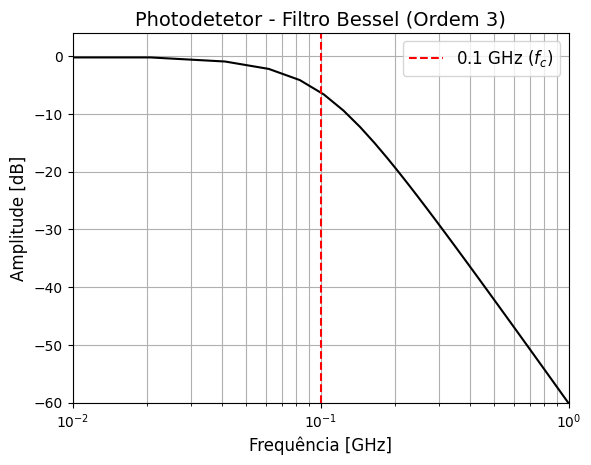

In [11]:
samp_freq = 2*Fs
cutoff_freq = 0.1e9  # TIA Filter cuttoff frequency in Hz  b   
order = 3      

w_pre = 2*samp_freq*np.tan(np.pi*cutoff_freq/samp_freq)        # rad/s  (pre-warped)

b,a = signal.bessel(N=order, Wn=w_pre, analog=True)
b_z, a_z = signal.bilinear(b, a, fs=samp_freq)
w, h = signal.freqz(b_z, a_z, worN=1024, fs=samp_freq)
FilteredIPd = signal.lfilter(b, a, IPd)

plt.plot(w*1e-9, 20 * np.log10(abs(h)), color='black')
plt.axvline(cutoff_freq*1e-9, color='red', linestyle='--', label=f'{cutoff_freq*1e-9} GHz ($f_c$)')
plt.xscale('log')
plt.xlim(0.01,1)
plt.ylim(-60,4)
plt.title(f'Photodetetor - Filtro Bessel (Ordem {order})',fontsize=14)
plt.xlabel('Frequência [GHz]',fontsize=12)
plt.ylabel('Amplitude [dB]',fontsize=12)
plt.grid(which='both', axis='both')
plt.legend(fontsize=12)

plt.savefig("PDBessel.pdf", format="pdf")

## Filtering Current

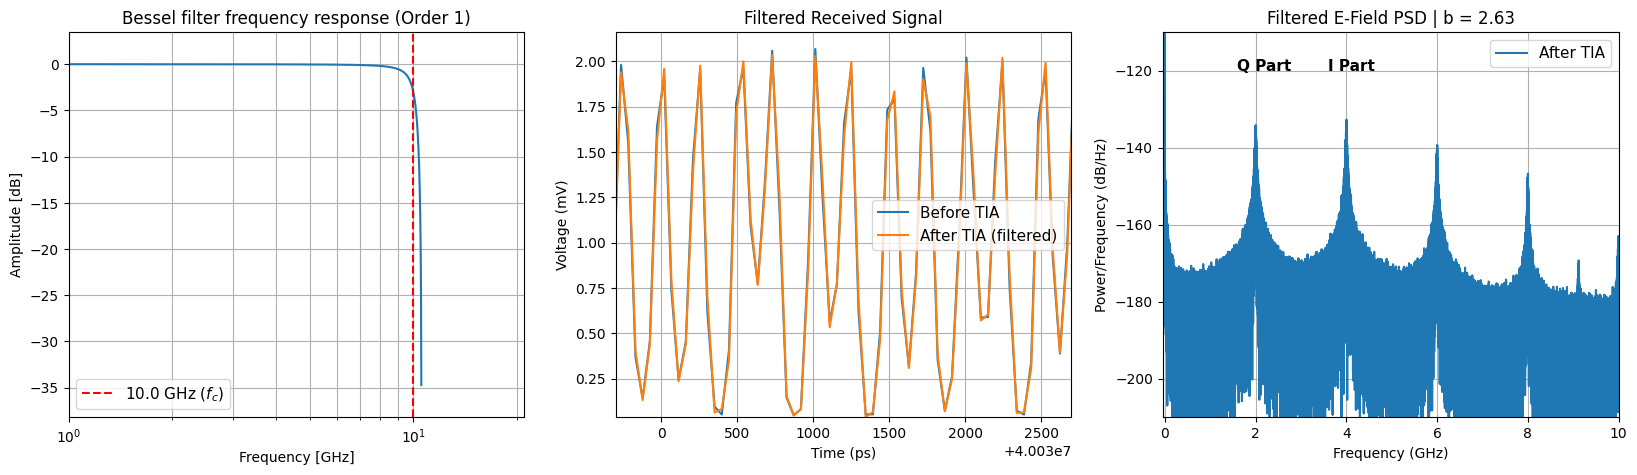

In [90]:
samp_freq = Fs
cutoff_freq = 10e9  # TIA Filter cuttoff frequency in Hz  b   
order = 1        

w_pre = 2*samp_freq*np.tan(np.pi*cutoff_freq/samp_freq)        # rad/s  (pre-warped)

b,a = signal.bessel(N=order, Wn=w_pre, analog=True)
b_z, a_z = signal.bilinear(b, a, fs=samp_freq)
w, h = signal.freqz(b_z, a_z, worN=1024, fs=samp_freq)
FilteredIPd = signal.lfilter(b_z, a_z, IPd)

fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

StTime = np.min(timeArray*1e12) # Starting time post delay

ax[0].plot(w*1e-9, 20 * np.log10(abs(h)))
ax[0].axvline(cutoff_freq*1e-9, color='red', linestyle='--', label=f'{cutoff_freq*1e-9} GHz ($f_c$)')
ax[0].set_xscale('log')
ax[0].set_xlim(1,21)
ax[0].set_title(f'Bessel filter frequency response (Order {order})')
ax[0].set_xlabel('Frequency [GHz]')
ax[0].set_ylabel('Amplitude [dB]')
ax[0].margins(0, 0.1)
ax[0].grid(which='both', axis='both')
ax[0].legend(fontsize=11)

ax[1].plot(timeArray*1e12,IPd*1e3, label='Before TIA')
ax[1].plot(timeArray*1e12,FilteredIPd*1e3, label='After TIA (filtered)')
ax[1].set_xlim(StTime+2000,StTime+5000)
ax[1].set_ylim(np.min(IPd[10000:])*1e3,np.max(IPd[10000:])*1e3)
ax[1].set_xlabel('Time (ps)')
ax[1].set_ylabel('Voltage (mV)')
ax[1].set_title('Filtered Received Signal')
ax[1].grid()
ax[1].legend(fontsize=11)

spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

ax[2].plot(freq*1e-9,10*np.log10(spectrum), label='After TIA')
ax[2].text(1.6,-120,'Q Part',fontweight='bold',fontsize=11)
ax[2].text(3.6,-120,'I Part',fontweight='bold',fontsize=11)
ax[2].set_xlabel('Frequency (GHz)')
ax[2].set_ylabel('Power/Frequency (dB/Hz)')
ax[2].set_xlim(-0.05,10)
ax[2].set_ylim(-210,-110)
ax[2].set_title(f'Filtered E-Field PSD | b = {bIdx}')
ax[2].grid()
ax[2].legend(fontsize=11)

## Demodulation

![Self-Heterodyne DSP Side Setup](../../IlustrationMedia/Delayed_Self_Heterodyne/DSP_Side.png)

The photodiode current can be defined as: 

$$i_{pd}(t) = -\frac{1}{2}\mathcal{R}P\left[ cos(\omega_0 \tau + \Delta \phi(t))\cdot cos(b sin(\omega_c t + \phi_c))\right] + \frac{1}{2}\mathcal{R}P\left[ sin(\omega_0 \tau + \Delta \phi(t))\cdot sin(b sin(\omega_c t + \phi_c)) \right]$$

By using Bessel Functions coefficient expasions, is possible to obtain in-phase $I(t)$ and quadrature $Q(t)$ components, which indicates that both can be obtained in DSP domain by demodulating using appropriate carriers. This is possible because the cosine terms with a modulating senoid at the argument can be expanded into Bessel functions with even ($cos(b sin(\omega_c t + \phi_c))$) or odd ($sin(b sin(\omega_c t + \phi_c))$) order:

$$\begin{cases} I(t)=-J_2(b)\mathcal{R} P \cdot cos(\omega_0 \tau + \Delta \phi(t))\cdot cos(2(\omega_c t + \phi_c))  \\  Q(t)=J_1(b)\mathcal{R} P \cdot sin(\omega_0 \tau + \Delta \phi(t))\cdot sin(\omega_c t + \phi_c) \end{cases}$$

Resulting from Bessel expansion analysis, $i_{pd}(t)$ can be demodulated with $-cos[2(\omega_c t + \phi_c)]$ (for $I(t)$) and $sin(\omega_c t + \phi_c)$ (for $Q(t)$), with $\phi_c$ being estimated prior demodulation by a simple Phase Recovery algorithm. Also, the best case to demodulate is when $J_1(b)=J_2(b)$, by adjusting $b$ is possible to equalize both functions (in this article, $b \approx 2.63$ was used). Here first, we will consider a case without a carrier recovery algorithm to estimate $\phi_c$

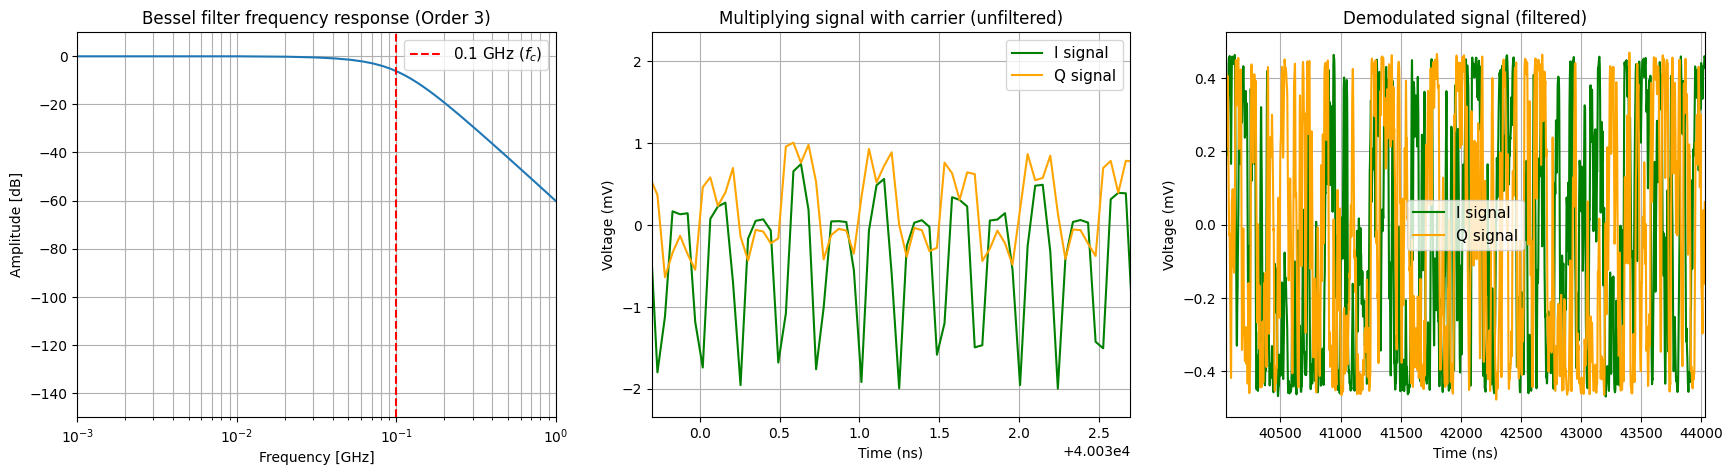

In [91]:
cutoff_freq = 0.1e9  # Filter cuttoff frequency in Hz   
order = 3          

Q_Sig = FilteredIPd*np.sin(2*np.pi*mFreq*timeArray+mPhase)
I_Sig = -FilteredIPd*np.cos(2*(2*np.pi*mFreq*timeArray+mPhase))

w_norm = cutoff_freq / (Fs/2)
b,a = signal.bessel(N=order, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredQ_Sig = signal.lfilter(b, a, Q_Sig)
FilteredI_Sig = signal.lfilter(b, a, I_Sig)

fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(21)

StTime = np.min(timeArray*1e9) # Starting time post delay

ax[0].plot(w*1e-9, 20 * np.log10(abs(h)))
ax[0].axvline(cutoff_freq*1e-9, color='red', linestyle='--', label=f'{cutoff_freq*1e-9} GHz ($f_c$)')
ax[0].set_xscale('log')
ax[0].set_xlim(0.001,1)
ax[0].set_ylim(-150,10)
ax[0].set_title(f'Bessel filter frequency response (Order {order})')
ax[0].set_xlabel('Frequency [GHz]')
ax[0].set_ylabel('Amplitude [dB]')
ax[0].margins(0, 0.1)
ax[0].grid(which='both', axis='both')
ax[0].legend(fontsize=11)

ax[1].plot(timeArray*1e9,I_Sig*1e3, label='I signal', color='green')
ax[1].plot(timeArray*1e9,Q_Sig*1e3, label='Q signal', color='orange')
ax[1].set_xlim(StTime+2,StTime+5)
ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('Voltage (mV)')
ax[1].set_title('Multiplying signal with carrier (unfiltered)')
ax[1].grid()
ax[1].legend(fontsize=11)

ax[2].plot(timeArray*1e9,FilteredI_Sig*1e3, label='I signal', color='green')
ax[2].plot(timeArray*1e9,FilteredQ_Sig*1e3, label='Q signal', color='orange')
ax[2].set_xlim(StTime+20,StTime+4000)
ax[2].set_xlabel('Time (ns)')
ax[2].set_ylabel('Voltage (mV)')
ax[2].set_title('Demodulated signal (filtered)')
ax[2].grid()
ax[2].legend(fontsize=11)

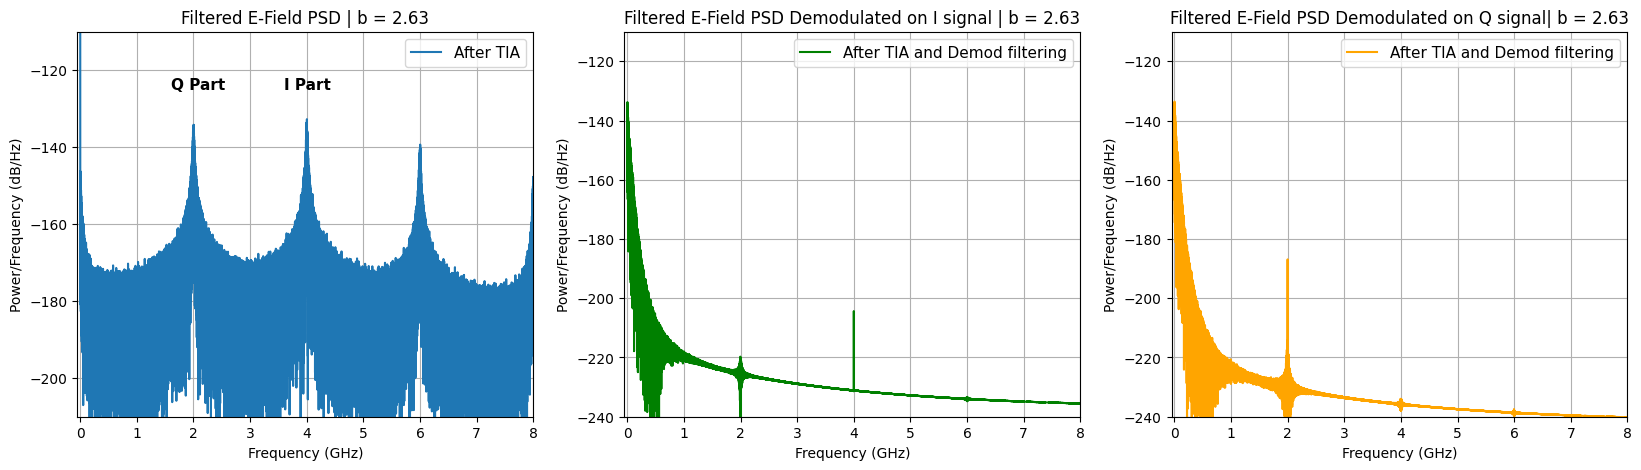

In [14]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

StTime = np.min(timeArray*1e12) # Starting time post delay

spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

ax[0].plot(freq*1e-9,10*np.log10(spectrum), label='After TIA')
ax[0].text(1.6,-125,'Q Part',fontweight='bold',fontsize=11)
ax[0].text(3.6,-125,'I Part',fontweight='bold',fontsize=11)
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Power/Frequency (dB/Hz)')
ax[0].set_xlim(-0.05,8)
ax[0].set_ylim(-210,-110)
ax[0].set_title(f'Filtered E-Field PSD | b = {bIdx}')
ax[0].grid()
ax[0].legend(fontsize=11)

spectrum = len(FilteredI_Sig)*np.abs(np.fft.fft(FilteredI_Sig, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(FilteredI_Sig),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

ax[1].plot(freq*1e-9,10*np.log10(spectrum), label='After TIA and Demod filtering', color='green')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1].set_xlim(-0.05,8)
ax[1].set_ylim(-240,-110)
ax[1].set_title(f'Filtered E-Field PSD Demodulated on I signal | b = {bIdx}')
ax[1].grid()
ax[1].legend(fontsize=11)

spectrum = len(FilteredQ_Sig)*np.abs(np.fft.fft(FilteredQ_Sig, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(FilteredQ_Sig),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

ax[2].plot(freq*1e-9,10*np.log10(spectrum), label='After TIA and Demod filtering', color='orange')
ax[2].set_xlabel('Frequency (GHz)')
ax[2].set_ylabel('Power/Frequency (dB/Hz)')
ax[2].set_xlim(-0.05,8)
ax[2].set_ylim(-240,-110)
ax[2].set_title(f'Filtered E-Field PSD Demodulated on Q signal| b = {bIdx}')
ax[2].grid()
ax[2].legend(fontsize=11)

## Phase-Noise Characterization

### E-Field PSD

The E-Field PSD function was already plotted. The laser linewidth is one-half of the measured linewidth of this self-heterodyne method (measured at the first or second harmonic)

leftMark between 1993.28 and 1993.29 MHz
BestleftMark: 1993.2771800876783 MHz
rightMark between 2006.74 and 2006.76 MHz
BestrightMark: 2006.7473632351305 MHz


<IPython.core.display.Math object>

KeyboardInterrupt: 

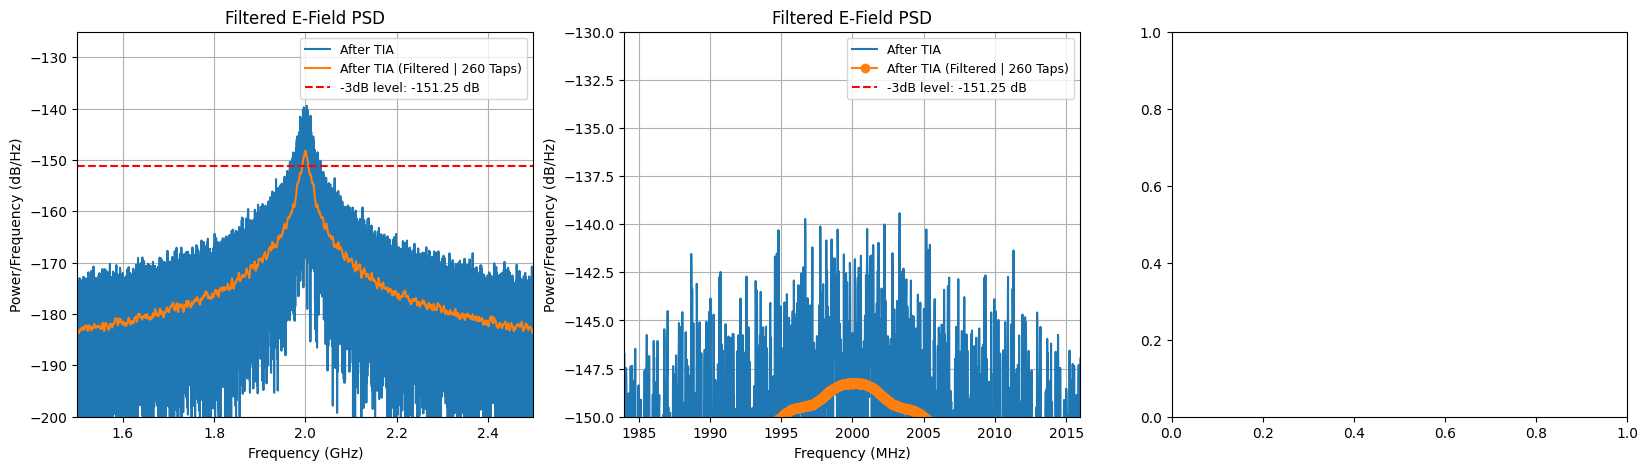

In [92]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

tapsArray = np.linspace(300,1600,10)
lwArray = np.zeros(len(tapsArray))

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]

# spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd,norm='forward'))**2 / Fs
# freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)
win = np.hamming(len(FilteredIPd))                       
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
FilteredIPd_win = FilteredIPd * win  
spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)


spectrum = spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 260
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

ax[0].plot(freq*1e-9,spectrum, label='After TIA')
ax[0].plot(freq[Ntaps:-Ntaps]*1e-9,FilteredSpec, label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[0].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Power/Frequency (dB/Hz)')
ax[0].set_xlim(1.5,2.5)
ax[0].set_ylim(-200,-125)
ax[0].set_title(f'Filtered E-Field PSD')
ax[0].grid()
ax[0].legend(fontsize=9)

ax[1].plot(freq*1e-6,spectrum, label='After TIA')
ax[1].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[1].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1].set_xlim(2000 - 16 , 2000 + 16)
ax[1].set_ylim(-150,-130)
ax[1].set_title(f'Filtered E-Field PSD')
ax[1].grid()
ax[1].legend(fontsize=9)

BestrightMark = 0
BestleftMark = 0

freqCutted = freq[Ntaps:-Ntaps].copy()

for i in range(len(FilteredSpec)-1):
    leftMark = 0
    rightMark = 0
    if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
        print(f'leftMark between {np.round(freqCutted[i]*1e-6,2)} and {np.round(freqCutted[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
        if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
        print(f'rightMark between {np.round(freqCutted[i]*1e-6,2)} and {np.round(freqCutted[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
        if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(delF, delF/2 )))

for j in range(len(tapsArray)):
    NtapsIt = int(np.floor(tapsArray[j]))
    b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

    BestrightMark = 0
    BestleftMark = 0

    freqCutted = freq[NtapsIt:-NtapsIt].copy()

    for i in range(len(FilteredSpec)-1):
        leftMark = 0
        rightMark = 0
        if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
            leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
                BestleftMark = leftMark
                # print(f'new bestleft = {BestleftMark}')
        elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
            rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
                BestrightMark = rightMark
                # print(f'new bestright = {BestrightMark}')
        # print(f'left and right: {leftMark} | {rightMark}')
    
    lwArray[j] = BestrightMark*1e-6-BestleftMark*1e-6

ax[2].plot(tapsArray,lwArray,'-o')
ax[2].set_xlabel('Number of Taps')
ax[2].set_ylabel('Measured Linewidth (MHz)')
ax[2].set_title(f'Linewidth x FIR Filter NTaps')
ax[2].hlines(delF,xmin=tapsArray[0], xmax=tapsArray[-1], color='red', linestyle='--', label=f'Measured lw with ({Ntaps} taps)')
ax[2].grid()
ax[2].legend(fontsize=10)

<IPython.core.display.Math object>

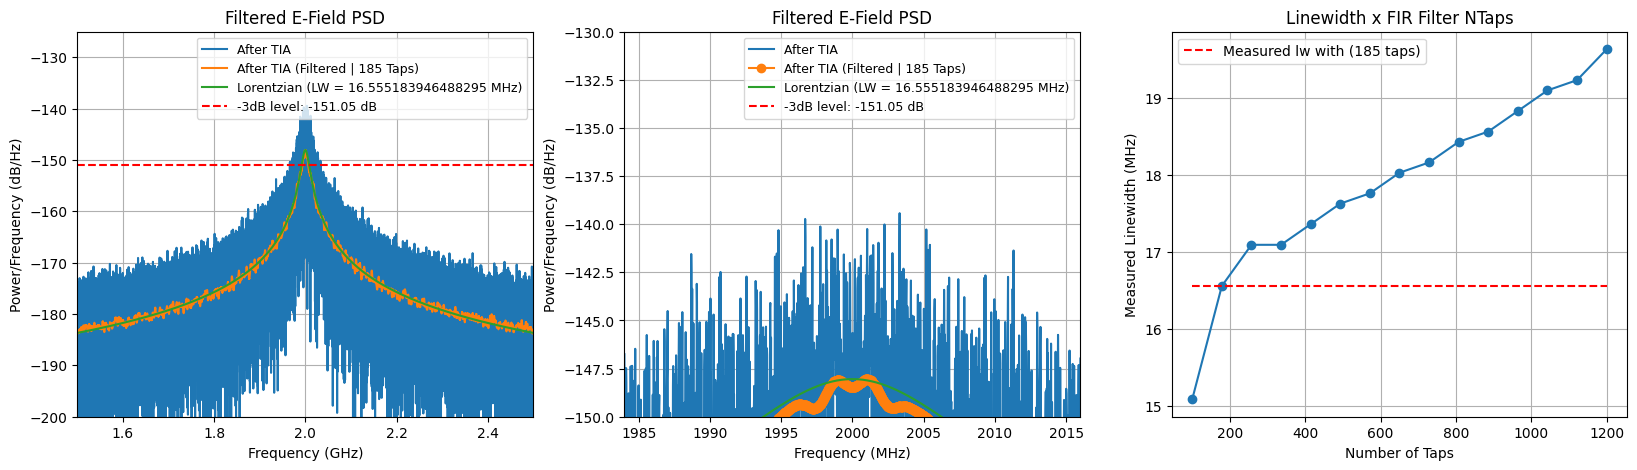

In [22]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]

win = np.hamming(len(FilteredIPd))                       
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
FilteredIPd_win = FilteredIPd * win  
spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)

# spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd,norm='forward'))**2 / Fs
# freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)

spectrum = spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 185
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

LorentzLWArray = np.linspace(10e6,50e6,300)
corArray = np.zeros(len(LorentzLWArray))

for i in range(len(LorentzLWArray)):
    delV = LorentzLWArray[i]
    LorentzS = 10*np.log10(1/(2*np.pi) * delV/((freq - centerFreq)**2 + (delV/2)**2))
    LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))
    corArray[i] = np.sum(np.abs(LorentzS[Ntaps:-Ntaps] - FilteredSpec)**2)

delV = LorentzLWArray[np.argmin(corArray)]
LorentzS = 10*np.log10(1/(2*np.pi) * delV/((freq - centerFreq)**2 + (delV/2)**2))
LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))

ax[0].plot(freq*1e-9,spectrum, label='After TIA')
ax[0].plot(freq[Ntaps:-Ntaps]*1e-9,FilteredSpec, label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[0].plot(freq[Ntaps:-Ntaps]*1e-9,LorentzS[Ntaps:-Ntaps], label=f'Lorentzian (LW = {delV*1e-6} MHz)')
ax[0].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Power/Frequency (dB/Hz)')
ax[0].set_xlim(1.5,2.5)
ax[0].set_ylim(-200,-125)
ax[0].set_title(f'Filtered E-Field PSD')
ax[0].grid()
ax[0].legend(fontsize=9)

ax[1].plot(freq*1e-6,spectrum, label='After TIA')
ax[1].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[1].plot(freq[Ntaps:-Ntaps]*1e-6,LorentzS[Ntaps:-Ntaps], label=f'Lorentzian (LW = {delV*1e-6} MHz)')
ax[1].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1].set_xlim(2000 - 16 , 2000 + 16)
ax[1].set_ylim(-150,-130)
ax[1].set_title(f'Filtered E-Field PSD')
ax[1].grid()
ax[1].legend(fontsize=9)

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(delV*1e-6, delV*1e-6/2 )))

tapsArray = np.linspace(100,1200,15)
lwArray = np.zeros(len(tapsArray))

for j in range(len(tapsArray)):
    NtapsIt = int(tapsArray[j])
    b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

    for i in range(len(LorentzLWArray)):
        delVit = LorentzLWArray[i]
        LorentzS = 10*np.log10(1/(2*np.pi) * delVit/((freq - centerFreq)**2 + (delVit/2)**2))
        LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))
        corArray[i] = np.sum(np.abs(LorentzS[NtapsIt:-NtapsIt] - FilteredSpec)**2)

    lwArray[j] = LorentzLWArray[np.argmin(corArray)]*1e-6

ax[2].plot(tapsArray,lwArray,'-o')
ax[2].set_xlabel('Number of Taps')
ax[2].set_ylabel('Measured Linewidth (MHz)')
ax[2].set_title(f'Linewidth x FIR Filter NTaps')
ax[2].hlines(delV*1e-6,xmin=tapsArray[0], xmax=tapsArray[-1], color='red', linestyle='--', label=f'Measured lw with ({Ntaps} taps)')
ax[2].grid()
ax[2].legend(fontsize=10)

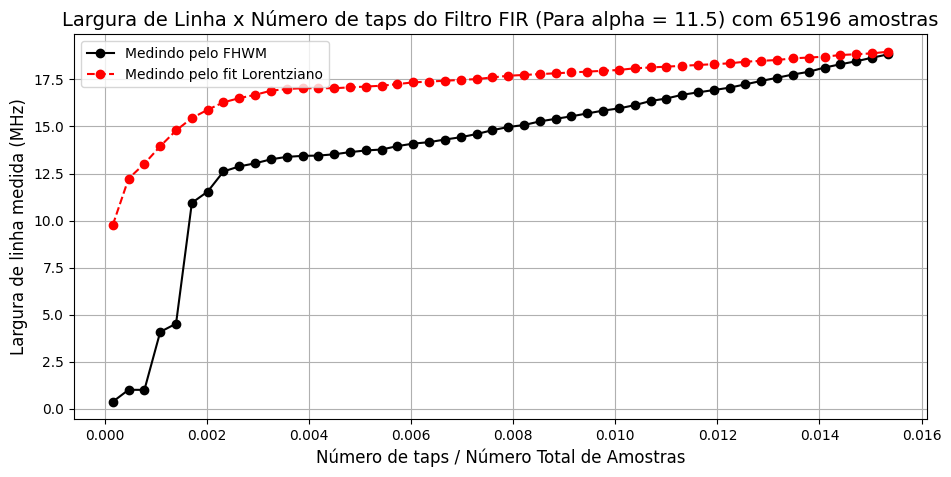

In [93]:
tapsArray = np.linspace(10,1000,50)
lwArray = np.zeros(len(tapsArray))
lwArray2 = np.zeros(len(tapsArray))

LorentzLWArray = np.linspace(1e6,45e6,1000)

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]

# spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd,norm='forward'))**2 / Fs
# freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)

win = np.hamming(len(FilteredIPd))                       
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
FilteredIPd_win = FilteredIPd * win  
spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)

spectrum = spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])
TotalN = len(spectrum)

for j in range(len(tapsArray)):
    NtapsIt = int(np.floor(tapsArray[j]))
    b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

    BestrightMark = 0
    BestleftMark = 0

    freqCutted = freq[NtapsIt:-NtapsIt].copy()

    for i in range(len(FilteredSpec)-1):
        if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
            leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
                BestleftMark = leftMark
        elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
            rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
                BestrightMark = rightMark
    
    lwArray[j] = BestrightMark*1e-6-BestleftMark*1e-6

    corArray = np.zeros(len(LorentzLWArray))

    for i in range(len(LorentzLWArray)):
        delVit = LorentzLWArray[i]
        LorentzS = 10*np.log10(1/(2*np.pi) * delVit/((freq - centerFreq)**2 + (delVit/2)**2))
        LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))
        corArray[i] = np.sum(np.abs(LorentzS[NtapsIt:-NtapsIt] - FilteredSpec)**2)

    lwArray2[j] = LorentzLWArray[np.argmin(corArray)]*1e-6

plt.figure(figsize=(11,5))
plt.plot(tapsArray/TotalN,lwArray,'-o',label='Medindo pelo FHWM', color='black')
plt.plot(tapsArray/TotalN,lwArray2,'--o',label='Medindo pelo fit Lorentziano', color='red')
plt.xlabel('Número de taps / Número Total de Amostras',fontsize=12)
plt.ylabel('Largura de linha medida (MHz)',fontsize=12)
plt.title(f'Largura de Linha x Número de taps do Filtro FIR (Para alpha = 11.5) com {int(TotalN)} amostras',fontsize=14)
plt.grid()
plt.legend(fontsize=10)

plt.savefig("FWHMxLorentzianFitDFB_11_5.pdf", format="pdf")

In [95]:
lwArray2

array([ 9.76476476, 12.23123123, 13.02402402, 13.94894895, 14.78578579,
       15.44644645, 15.88688689, 16.28328328, 16.5035035 , 16.67967968,
       16.8998999 , 16.98798799, 17.03203203, 17.03203203, 17.03203203,
       17.07607608, 17.12012012, 17.16416416, 17.25225225, 17.34034034,
       17.38438438, 17.42842843, 17.47247247, 17.51651652, 17.6046046 ,
       17.69269269, 17.73673674, 17.78078078, 17.82482482, 17.86886887,
       17.91291291, 17.95695696, 18.001001  , 18.08908909, 18.13313313,
       18.17717718, 18.22122122, 18.26526527, 18.30930931, 18.35335335,
       18.44144144, 18.48548549, 18.52952953, 18.61761762, 18.66166166,
       18.70570571, 18.79379379, 18.83783784, 18.88188188, 18.96996997])

In [96]:
FWHMset15 = np.array([ 2.1682077 ,  0.14086419,  3.25853414,  5.89466005,  6.28594215,
       17.51045004, 18.17740248, 18.6055691 , 18.91139894, 19.18500034,
       19.50014712, 20.0620322 , 21.96731562, 22.72134895, 23.06337395,
       23.18411336, 23.20324124, 23.20600277, 23.07070472, 22.9913485 ,
       22.93980483, 22.91515607, 22.98641453, 23.03284193, 23.1078926 ,
       23.20065065, 23.27028721, 23.32867949, 23.41638206, 23.46108943,
       23.56083509, 23.6230811 , 23.68980206, 23.69973163, 23.76221212,
       23.81740496, 23.89001148, 23.997766  , 24.11798464, 24.24266956,
       24.31650084, 24.43596073, 24.48350566, 24.56422136, 24.62405033,
       24.7280268 , 24.80317788, 24.89386114, 24.92118669, 25.01723437])

FWHMset11_5 = np.array([ 0.3791133 ,  1.0129196 ,  1.00881557,  4.0877719 ,  4.525381  ,
       10.94193478, 11.54027399, 12.60986971, 12.87923106, 13.04113411,
       13.25460222, 13.38498982, 13.43753911, 13.4531093 , 13.52131703,
       13.63697843, 13.72525689, 13.77555963, 13.9564136 , 14.08932499,
       14.16648225, 14.30577304, 14.42831438, 14.59628407, 14.80187818,
       14.97111227, 15.07556866, 15.26887723, 15.40584407, 15.53955954,
       15.69198782, 15.8417606 , 15.95882034, 16.13056755, 16.35213183,
       16.48507139, 16.68087733, 16.81197253, 16.93262345, 17.06164466,
       17.23729879, 17.41853546, 17.58574059, 17.75973566, 17.9029178 ,
       18.12857459, 18.30193419, 18.46236841, 18.65055152, 18.82713206])

FWHMset13_25 = np.array([ 0.49902823,  1.51928982,  4.82476123,  5.2367512 ,  5.41739688,
        9.12721631,  9.28353389, 14.42714368, 14.5428684 , 14.64053693,
       14.70265514, 14.7826587 , 14.84322319, 14.89012848, 14.97532724,
       15.04529665, 15.11875451, 15.33575209, 15.55715465, 15.81339589,
       16.04979625, 16.3207182 , 16.5598579 , 16.84821678, 17.1867411 ,
       17.51477147, 17.70222424, 17.89910797, 18.1551213 , 18.47900768,
       18.71688152, 18.93261242, 19.08715013, 19.23650109, 19.40502711,
       19.57699302, 19.70742218, 19.8728291 , 20.02421441, 20.17881543,
       20.33386081, 20.47658237, 20.63004808, 20.79745374, 20.97259657,
       21.05456545, 21.16272538, 21.357301  , 21.52546494, 21.69738816])

FWHMset8 = np.array([ 0.98532223,  2.95320529,  2.98575351,  3.20788648,  4.33339965,
        4.31657247,  4.38629877,  4.44120876,  4.48525471,  4.58920649,
        4.68378137,  4.78498886,  4.91252573,  5.06373109,  5.27679518,
        5.55099714,  5.84391472,  6.13742775,  6.38221616,  6.63495049,
        6.93490606,  7.24419917,  7.49007168,  7.75389243,  7.99326855,
        8.21066107,  8.36084699,  8.50639366,  8.7094739 ,  8.89350332,
        9.07274196,  9.23491041,  9.35922879,  9.48321782,  9.60825239,
        9.76583652,  9.90473377, 10.05878103, 10.2124463 , 10.34198892,
       10.44152564, 10.54258781, 10.63853788, 10.78823123, 10.90213874,
       11.04304061, 11.14285994, 11.26171048, 11.38673052, 11.50555144])

In [97]:
Lorentset15 = np.array([14.96196196, 21.3043043 , 22.97797798, 23.46246246, 24.12312312,
       24.91591592, 25.62062062, 26.19319319, 26.76576577, 27.16216216,
       27.6026026 , 27.998999  , 28.26326326, 28.48348348, 28.7037037 ,
       28.87987988, 29.01201201, 29.1001001 , 29.1001001 , 29.1001001 ,
       29.05605606, 29.1001001 , 29.14414414, 29.14414414, 29.18818819,
       29.23223223, 29.27627628, 29.27627628, 29.32032032, 29.32032032,
       29.32032032, 29.32032032, 29.36436436, 29.36436436, 29.36436436,
       29.36436436, 29.40840841, 29.40840841, 29.45245245, 29.45245245,
       29.4964965 , 29.4964965 , 29.4964965 , 29.54054054, 29.54054054,
       29.54054054, 29.58458458, 29.58458458, 29.58458458, 29.58458458])

Lorentset11_5 = np.array([ 9.76476476, 12.23123123, 13.02402402, 13.94894895, 14.78578579,
       15.44644645, 15.88688689, 16.28328328, 16.5035035 , 16.67967968,
       16.8998999 , 16.98798799, 17.03203203, 17.03203203, 17.03203203,
       17.07607608, 17.12012012, 17.16416416, 17.25225225, 17.34034034,
       17.38438438, 17.42842843, 17.47247247, 17.51651652, 17.6046046 ,
       17.69269269, 17.73673674, 17.78078078, 17.82482482, 17.86886887,
       17.91291291, 17.95695696, 18.001001  , 18.08908909, 18.13313313,
       18.17717718, 18.22122122, 18.26526527, 18.30930931, 18.35335335,
       18.44144144, 18.48548549, 18.52952953, 18.61761762, 18.66166166,
       18.70570571, 18.79379379, 18.83783784, 18.88188188, 18.96996997])

Lorentset13_25 = np.array([12.4954955 , 16.59159159, 18.22122122, 19.67467467, 20.2032032 ,
       20.55555556, 20.73173173, 20.86386386, 20.95195195, 21.08408408,
       21.12812813, 21.17217217, 21.21621622, 21.17217217, 21.21621622,
       21.21621622, 21.26026026, 21.39239239, 21.48048048, 21.61261261,
       21.7007007 , 21.78878879, 21.87687688, 22.00900901, 22.14114114,
       22.22922923, 22.36136136, 22.44944945, 22.53753754, 22.71371371,
       22.8018018 , 22.93393393, 23.02202202, 23.11011011, 23.1981982 ,
       23.28628629, 23.33033033, 23.41841842, 23.46246246, 23.55055055,
       23.63863864, 23.68268268, 23.77077077, 23.85885886, 23.94694695,
       23.99099099, 24.03503504, 24.12312312, 24.21121121, 24.2992993 ])

Lorentset8 = np.array([ 5.14014014,  6.28528529,  6.46146146,  6.54954955,  6.72572573,
        6.9019019 ,  7.03403403,  7.07807808,  7.16616617,  7.21021021,
        7.2982983 ,  7.38638639,  7.43043043,  7.47447447,  7.56256256,
        7.65065065,  7.73873874,  7.82682683,  7.91491491,  8.003003  ,
        8.09109109,  8.17917918,  8.31131131,  8.3993994 ,  8.48748749,
        8.57557558,  8.61961962,  8.70770771,  8.7957958 ,  8.88388388,
        8.92792793,  9.01601602,  9.06006006,  9.14814815,  9.19219219,
        9.28028028,  9.36836837,  9.41241241,  9.5005005 ,  9.58858859,
        9.63263263,  9.67667668,  9.76476476,  9.80880881,  9.8968969 ,
        9.94094094, 10.02902903, 10.07307307, 10.16116116, 10.20520521])

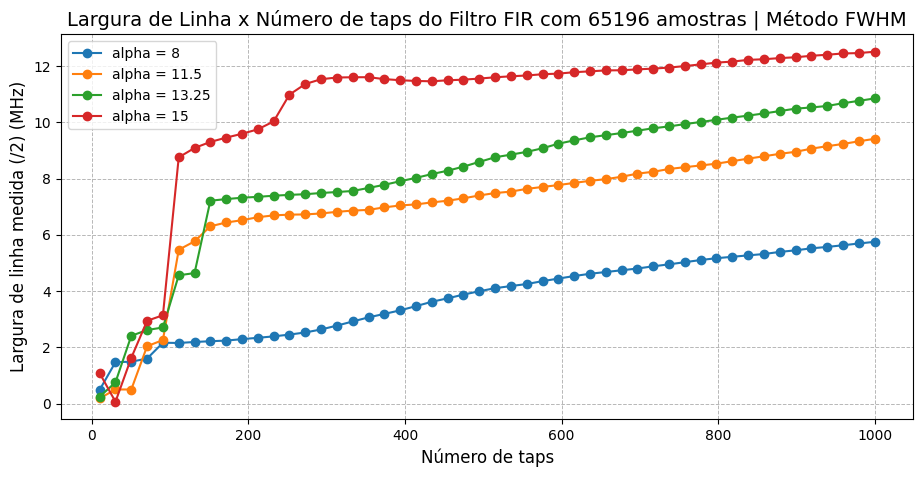

In [102]:
plt.figure(figsize=(11,5))
plt.plot(tapsArray,FWHMset8/2,'-o',label=f'alpha = 8')
plt.plot(tapsArray,FWHMset11_5/2,'-o',label=f'alpha = 11.5')
plt.plot(tapsArray,FWHMset13_25/2,'-o',label=f'alpha = 13.25')
plt.plot(tapsArray,FWHMset15/2,'-o',label=f'alpha = 15')
plt.xlabel('Número de taps',fontsize=12)
plt.ylabel('Largura de linha medida (/2) (MHz)',fontsize=12)
plt.title(f'Largura de Linha x Número de taps do Filtro FIR com {int(TotalN)} amostras | Método FWHM',fontsize=14)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.9)
plt.legend(fontsize=10)

plt.savefig("FWHMSweepDFB.pdf", format="pdf")

In [112]:
Lorentset15[8]/2

13.382882885

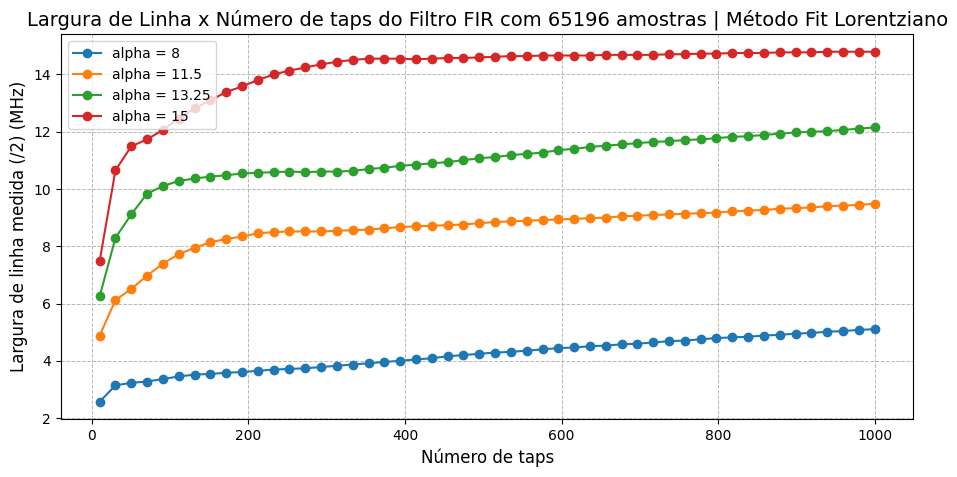

In [103]:
plt.figure(figsize=(11,5))
plt.plot(tapsArray,Lorentset8/2,'-o',label=f'alpha = 8')
plt.plot(tapsArray,Lorentset11_5/2,'-o',label=f'alpha = 11.5')
plt.plot(tapsArray,Lorentset13_25/2,'-o',label=f'alpha = 13.25')
plt.plot(tapsArray,Lorentset15/2,'-o',label=f'alpha = 15')
plt.xlabel('Número de taps',fontsize=12)
plt.ylabel('Largura de linha medida (/2) (MHz)',fontsize=12)
plt.title(f'Largura de Linha x Número de taps do Filtro FIR com {int(TotalN)} amostras | Método Fit Lorentziano',fontsize=14)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.9)
plt.legend(fontsize=10)

plt.savefig("LorentzSweepDFB.pdf", format="pdf")

### Frequency Modulation Noise Spectrum

Fs = 21.12 GSamples/s
[0.00000000e+00 1.71460999e+04 3.42921997e+04 ... 1.05599400e+10
 1.05599571e+10 1.05599743e+10]


C:\Users\Caio\AppData\Local\Temp\ipykernel_24132\1078380856.py:65: RuntimeWarning: invalid value encountered in divide
  convertedSpectrum = spectrumDPhase*freqDPhase**2/(4*np.sin(np.pi*freqDPhase*Ts)**2)


<IPython.core.display.Math object>

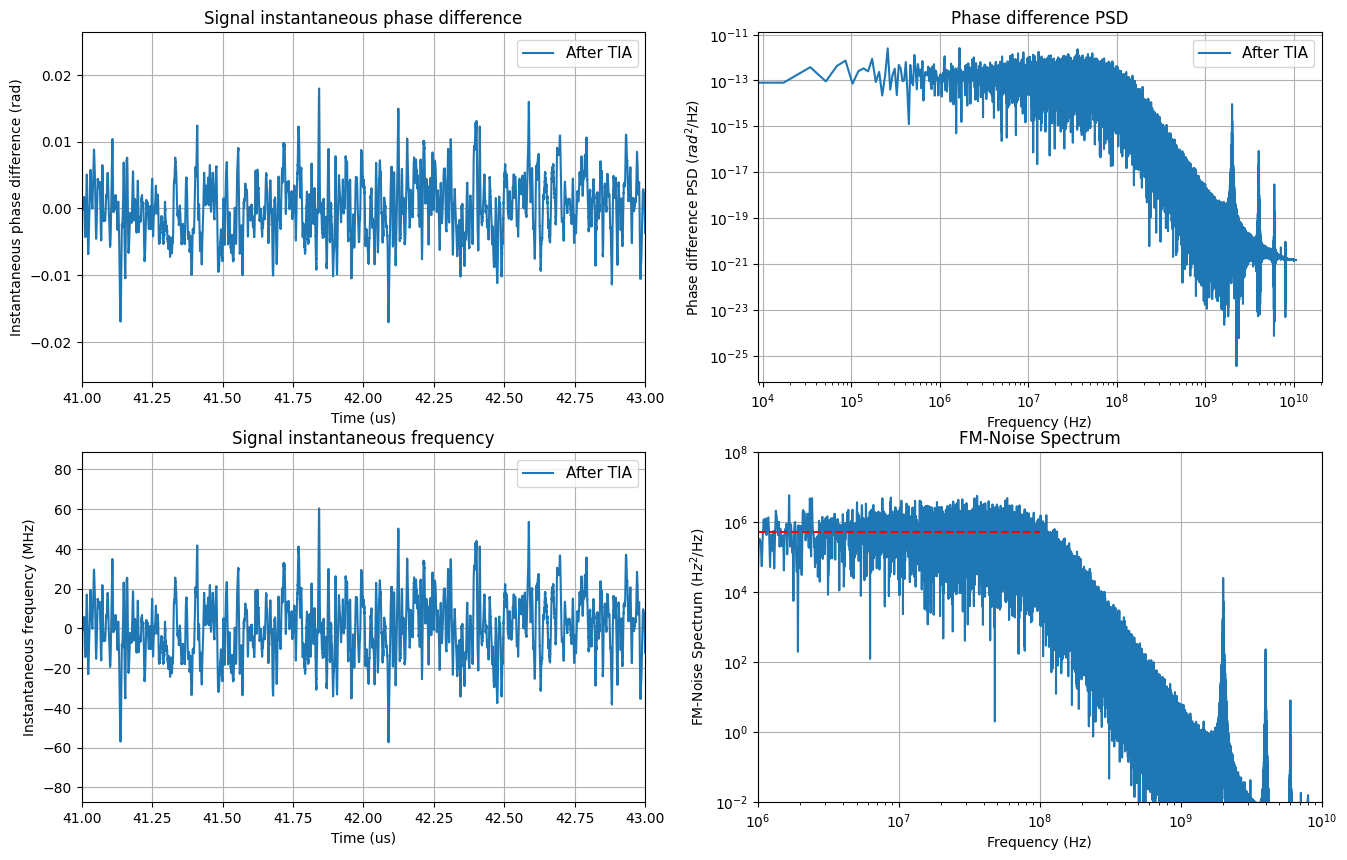

In [80]:
CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
# CplxSig = I_Sig + 1j*Q_Sig
instPhaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),1,cval=0)     # Instantaneous phase difference
instFreq = instPhaseDiff / (2*np.pi*Ts)                                                         # Instantaneous frequency

print(f'Fs = {(1/Ts)*1e-9} GSamples/s')

fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(16)

StTime = np.min(timeArray*1e6) # Starting time post delay

instPhaseDiff = instPhaseDiff[10000:-10000]
# spectrumDPhase, freqDPhase = mlab.magnitude_spectrum(instPhaseDiff, Fs=Fs, window=mlab.window_none,sides='onesided')
# spectrumDPhase = spectrumDPhase*np.conj(spectrumDPhase)
freqDPhase = np.fft.fftfreq(len(instPhaseDiff), d=1/Fs)
freqDPhase = freqDPhase[:int(len(freqDPhase)/2)]
spectrumDPhase = len(instPhaseDiff)*np.abs(np.fft.fft(instPhaseDiff,norm='forward'))**2/(Fs)
spectrumDPhase = 2*spectrumDPhase[:int(len(spectrumDPhase)/2)]

ax[0][0].plot(timeArray[10000:-10000]*1e6,instPhaseDiff, label='After TIA')
ax[0][0].set_xlabel('Time (us)')
ax[0][0].set_ylabel('Instantaneous phase difference (rad)')
ax[0][0].set_title(f'Signal instantaneous phase difference')
ax[0][0].set_xlim(41 , 43)
ax[0][0].grid()
ax[0][0].legend(fontsize=11)

ax[0][1].plot(freqDPhase,spectrumDPhase, label='After TIA')
ax[0][1].set_xscale('log')
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel('Frequency (Hz)')
ax[0][1].set_ylabel('Phase difference PSD ($rad^2$/Hz)')
# ax[0][1].set_xlim(1e6 , 1e10)
# ax[0][1].set_ylim(1e1 , 1e13)
ax[0][1].set_title(f'Phase difference PSD')
ax[0][1].grid()
ax[0][1].legend(fontsize=11)

instFreq = instFreq[10000:-10000]
instFreq = instFreq-np.mean(instFreq)

win = np.hamming(len(instFreq))                        
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2)
instFreq_win = instFreq * win  
spectrum =  np.abs(np.fft.fft(instFreq_win, norm='forward'))**2 / ENBW
freq = np.fft.fftfreq(len(instFreq), d=1/Fs)

# freq = np.fft.fftfreq(len(instFreq), d=1/Fs)
freq = freq[:int(len(freq)/2)]
# spectrum = len(instFreq)*np.abs(np.fft.fft(instFreq,norm='forward'))**2/(Fs)
spectrum = 2*spectrum[:int(len(spectrum)/2)]

ax[1][0].plot(timeArray[10000:-10000]*1e6,instFreq*1e-6, label='After TIA')
ax[1][0].set_xlabel('Time (us)')
ax[1][0].set_xlim(41 , 43)
# ax[0].set_xlim(StTime+0.1,StTime+0.3)
# ax[0].set_ylim(-100,100)
ax[1][0].set_ylabel('Instantaneous frequency (MHz)')
ax[1][0].set_title(f'Signal instantaneous frequency')
ax[1][0].grid()
ax[1][0].legend(fontsize=11)

convertedSpectrum = spectrumDPhase*freqDPhase**2/(4*np.sin(np.pi*freqDPhase*Ts)**2)

cutLims = [1e6,1e8]
initFreq = int(cutLims[0]/freq[-1]*len(freq))
endFreq = int(cutLims[1]/freq[-1]*len(freq))
Measurefreq = freq[initFreq:endFreq]
Measurespectrum = spectrum[initFreq:endFreq]
print(freq)

initFreqDP = int(cutLims[0]/freqDPhase[-1]*len(freqDPhase))
endFreqDP = int(cutLims[1]/freqDPhase[-1]*len(freqDPhase))
MeasurefreqDP = freqDPhase[initFreqDP:endFreqDP]
MeasurespectrumDP = convertedSpectrum[initFreqDP:endFreqDP]

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz~~~|~~~Linewidth~(with~correction~factor) = %5.6f~MHz' 
             %(np.round(np.pi*np.mean(Measurespectrum)*1e-6,5), np.round(np.pi*np.mean(Measurespectrum)*1e-6/2,5), np.round(4.8*np.pi*np.mean(Measurespectrum)*1e-6/2,5)) ))

ax[1][1].plot(freq,spectrum, label='FM-Noise PSD')
# ax[1][1].plot(freqDPhase,convertedSpectrum, label='FM-Noise PSD from Phase difference PSD')
ax[1][1].hlines(np.mean(Measurespectrum),xmin=cutLims[0], xmax=cutLims[1], color='red', linestyle='--', label=f'{np.round(np.mean(Measurespectrum)*1e-6,2)} MHz')
# ax[1][1].hlines(np.mean(MeasurespectrumDP),xmin=cutLims[0], xmax=cutLims[1], color='green', linestyle='--', label=f'{np.round(np.mean(MeasurespectrumDP)*1e-6,2)} MHz (from phase difference PSD)')
ax[1][1].set_xscale('log')
ax[1][1].set_yscale('log')
ax[1][1].set_xlabel('Frequency (Hz)')
ax[1][1].set_ylabel('FM-Noise Spectrum (H$z^2$/Hz)')
ax[1][1].set_xlim(1e6 , 1e10)
ax[1][1].set_ylim(1e-2 , 1e8)
ax[1][1].set_title(f'FM-Noise Spectrum')
ax[1][1].grid()
# ax[1][1].legend(fontsize=11)

### Phase-Error Variance

If the laser phase noise was considered as a random walk, the measured phase-error variance is represented by: $$ \sigma^2_{\Delta \phi}(\tau_i) = \left\langle \left( \Delta \phi(t) - \Delta \phi(t - \tau_i) \right)^2 \right\rangle $$

The linewidth ($\Delta f$) can be calculated by $ \sigma^2_{\Delta \phi}(\tau) = 2 \pi \Delta f \cdot \tau$. Therefore, taking the slope of the $\sigma^2_{\Delta \phi}(\tau)$ curve we get:
$$ \frac{d}{d \tau}(\sigma^2_{\Delta \phi}(\tau)) = \frac{d}{d \tau}(2 \pi \Delta f \cdot \tau) ~~~~\Rightarrow~~~~ \frac{d}{d \tau}(a\cdot \tau + b) = a = 2 \pi \Delta f$$
Not forgeting to dividing $\Delta f$ by 2 to find the real laser linewidth, due to the self-heterodyne metodology.


<IPython.core.display.Math object>

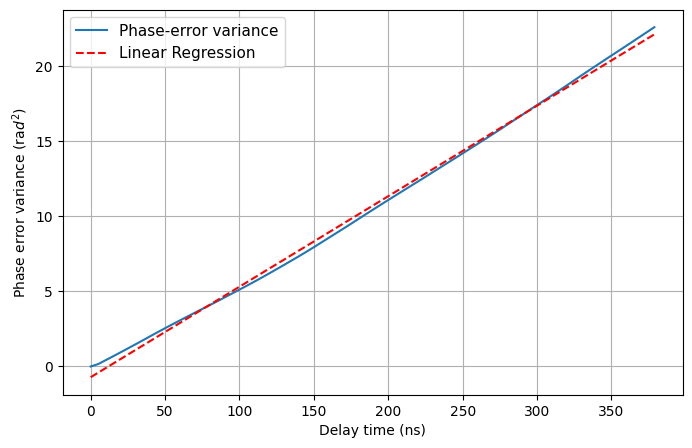

In [81]:
ShiftArray = np.linspace(0,8000,75)

CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
varianceArray = np.zeros(len(ShiftArray))

for i in range(len(ShiftArray)):
    phaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),ShiftArray[i],cval=0)  # Instantaneous frequency
    varianceArray[i] = np.mean(phaseDiff[200+int(ShiftArray[i]):]**2)

polyArray = np.polyfit(ShiftArray[:900]*Ts,varianceArray[:900],1)

plt.figure(figsize=(8,5))
plt.plot(ShiftArray*Ts*1e9,varianceArray,label='Phase-error variance')
plt.plot(ShiftArray*Ts*1e9,polyArray[0]*ShiftArray*Ts+polyArray[1],'--',color='red',label='Linear Regression')
plt.ylabel('Phase error variance (ra$d^2$)')
plt.xlabel('Delay time (ns)')
plt.grid()
plt.legend(fontsize=11)

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(polyArray[0]*1e-6/(2*np.pi) , (polyArray[0]*1e-6/(2*np.pi))/2 )))

# Entire Process

In [ ]:
TIACutFreq = 4e9  # TIA Filter cuttoff frequency in Hz   
TIAorder = 4  # TIA Filter order      

DemodCutFreq = 0.1e9  # Demodulation Filter cuttoff frequency in Hz     
Demodorder = 3  # Demodulation Filter order

tau = SMFLen/(c*1e-3)    # Fiber Delay
shiftValue = int(len(loadedt)*tau/loadedt[-1])

EUpper = linearFiberChannel(loadede_out*np.sqrt(KConst),LinearFiber_parameters)  
EUpper = shift(EUpper,shiftValue,cval=EUpper[0])
EUpper = EUpper[shiftValue:]

carrier = loadede_out*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
EBottom = carrier*np.exp(1j*bIdx*np.sin(2*np.pi*mFreq*loadedt+mPhase))
EBottom = EBottom[shiftValue:]

timeArray = loadedt[shiftValue:]

Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode


# TIA Filter ---------------------------------------------------------

w_norm = TIACutFreq / (Fs/2)
b,a = signal.bessel(N=TIAorder, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredIPd = signal.lfilter(b, a, IPd)

Q_Sig = FilteredIPd*np.sin(2*np.pi*mFreq*timeArray+mPhase)
I_Sig = -FilteredIPd*np.cos(2*(2*np.pi*mFreq*timeArray+mPhase))

# Demodulation Filtering ----------------------------------------------      

w_norm = DemodCutFreq / (Fs/2)
b,a = signal.bessel(N=Demodorder, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredQ_Sig = signal.lfilter(b, a, Q_Sig)
FilteredI_Sig = signal.lfilter(b, a, I_Sig)

# Complex Signal Construction ------------------------------------------ 

CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
instFreq = (np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),1,cval=0)) / (2*np.pi*Ts) # Instantaneous frequency

SMF Delay = 40.02769142377824 us


In [ ]:
import numpy as np

valores = {
    15:      [11.36, 13.38, 14.25, 13.77],
    13.25:   [7.46, 10.48, 11.55, 11.77],
    11.5:    [6.73, 8.25, 8.82, 9.23],
    9.75:    [np.nan, np.nan, np.nan, np.nan],
    8:       [2.53, 3.58, 4.07, 4.80]
}

# Erros percentuais médios convertidos para decimais
erros = {
    'FWHM': 0.1856,
    'Fit': 0.0630,
    'FM-Noise': 0.0183,
    'Variancia': 0.0605
}

# Calcula pesos como 1/erro
pesos = {
    metodo: 1/erro for metodo, erro in erros.items()
}

# Função para calcular a média ponderada ignorando NaNs
def media_ponderada(valores_linha, pesos):
    soma_pesos = 0
    soma_valores = 0
    nomes = ['FWHM', 'Fit', 'FM-Noise', 'Variancia']
    for valor, nome in zip(valores_linha, nomes):
        if not np.isnan(valor):
            soma_pesos += pesos[nome]
            soma_valores += pesos[nome] * valor
    if soma_pesos == 0:
        return np.nan
    return soma_valores / soma_pesos

# Calculando para cada α
resultado = {}
for alpha, valores_linha in valores.items():
    resultado[alpha] = media_ponderada(valores_linha, pesos)

# Exibe resultados
print("Médias ponderadas:")
for alpha, media in resultado.items():
    print(f"\u03b1 = {alpha}: {media:.2f} MHz")

Médias ponderadas:
α = 15: 13.85 MHz
α = 13.25: 11.17 MHz
α = 11.5: 8.67 MHz
α = 9.75: nan MHz
α = 8: 4.03 MHz


In [116]:
ExpectLW = np.array([4.03,8.67,11.17,13.85])
FWHMmeasure = np.array([2.53,6.73,7.46,11.36])
Lorentzmeasure = np.array([3.58,8.25,10.48,13.38])
FMmeasure = np.array([4.07,8.82,11.55,14.25])
Variancemeasure = np.array([4.80,9.23,11.77,13.77])

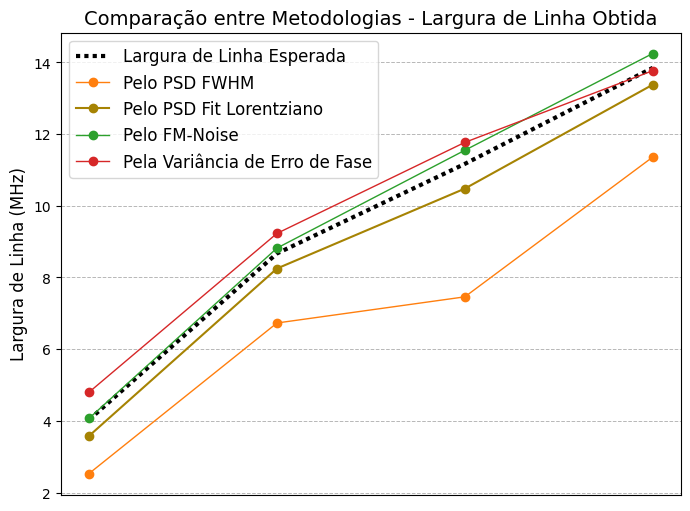

In [120]:
plt.figure(figsize=(8,6))
plt.plot(ExpectLW, color='black', linestyle=(0, (1, 1)), linewidth=3, markersize=5, label='Largura de Linha Esperada')
plt.plot(FWHMmeasure,'-o',color='C1',linewidth=1,label='Pelo PSD FWHM')
plt.plot(Lorentzmeasure,'-o',color='#a68303',linewidth=1.5,label='Pelo PSD Fit Lorentziano')
plt.plot(FMmeasure,'-o',color='C2',linewidth=1,label='Pelo FM-Noise')
plt.plot(Variancemeasure,'-o',color='C3',linewidth=1,label='Pela Variância de Erro de Fase')

plt.ylabel('Largura de Linha (MHz)',fontsize=12)
plt.xticks([])
plt.title('Comparação entre Metodologias - Largura de Linha Obtida',fontsize=14)
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.9)

plt.savefig("MethodsLWDFB.pdf", format="pdf")